# Chapter 2 - Basic statistics

## Install Python libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip3 install statsmodels scipy statistics seaborn nltk scikit-learn

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import urllib
import datetime as dt
import sys
import re

import nltk
from nltk.corpus import brown

from operator import itemgetter    

# Statistics
import statistics as stats
import scipy.interpolate as interpolate
import statsmodels.datasets
import matplotlib
from numpy import std
from scipy import signal
from scipy.stats import norm, sem, binom, lognorm, poisson, bernoulli, spearmanr, pareto, expon
from scipy.ndimage.filters import gaussian_filter1d

from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

from math import sqrt
from numpy.random import normal
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup


## Plot settings

In [3]:
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 14),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

xxlarge = 16
xlarge = 16
large = 12

plt.rcParams.update(params)
plt.rcParams['font.size'] = 26
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot style
sns.set()
sns.set_style("white")

# PDF (Continuous variables)
**Example 2.1**. A histogram is a visual representation of count data for a random variable, grouped in a similar manner to a bar chart. The histogram for the heights of a sample of women recorded in a telephone survey in the United States in 1990 (see Table 2.1), is shown on the top-left of Figure 2.1. The corresponding fitted PDF is shown on the top-right of Figure 2.1. We note that the histogram can be viewed as an approximation to the normal distribution (introduced below), and that the PDF is generated from the parameters resulting from maximum likelihood fitting of the normal distribution to the data set. (Maximum likelihood is a well-established method for estimating the parameters of a distribution that is assumed to fit the data.) 

A further plot of the CDF is shown on the bottom-left of Figure 2.1, and a plot of the empirical cumulative distribution function (ECDF, introduced at the end of Section 2.1), is shown on the bottom-right of Figure 2.1

In [4]:
# Helper functions for generating the ECDF
class StepFunction:
    def __init__(self, x, y, ival=0.0, sorted=False, side="left"):
        if side.lower() not in ["right", "left"]:
            msg = "side can take the values 'right' or 'left'"
            raise ValueError(msg)
        self.side = side
        _x = np.asarray(x)
        _y = np.asarray(y)
        if _x.shape != _y.shape:
            msg = "x and y do not have the same shape"
            raise ValueError(msg)
        if len(_x.shape) != 1:
            msg = "x and y must be 1-dimensional"
            raise ValueError(msg)
        self.x = np.r_[-np.inf, _x]
        self.y = np.r_[ival, _y]
        if not sorted:
            asort = np.argsort(self.x)
            self.x = np.take(self.x, asort, 0)
            self.y = np.take(self.y, asort, 0)
        self.n = self.x.shape[0]

    def __call__(self, time):
        tind = np.searchsorted(self.x, time, self.side) - 1
        return self.y[tind]


class ECDF(StepFunction):
    def __init__(self, x, side="right"):
        x = np.array(x, copy=True)
        x.sort()
        nobs = len(x)
        y = np.linspace(1.0 / nobs, 1, nobs)
        super(ECDF, self).__init__(x, y, side=side, sorted=True)

df = pd.read_csv('./data/weight-height.csv', delimiter="\t")

# Restrict to just female data points
df = df[df['Gender']=='Female']
df['Height'] = df['Height']  * 2.54
df['Weight']  = df['Weight'] / 2.2046

# Calculate mean and standard deviations as we need them to 
# generate a normal distribution.
heights = df['Height'].tolist()

meanx = np.mean(heights)
std_val = np.std(heights)
distribution = norm(meanx, std_val)

# Choose the range on which to plot the PDF.
min_height = min(heights)
max_height = max(heights)
values = list(range(int(min_height), int(max_height)))

# Generate probabilities for that range.
probabilities = [distribution.pdf(v) for v in values]


In [5]:
print(df.round(2).head())

      Gender  Weight  Height
5000  Female   46.31  149.63
5001  Female   64.10  165.68
5002  Female   59.44  160.96
5003  Female   58.14  163.78
5004  Female   58.87  156.95


Table 2.1: A sample of the data for height (in centimeters) and weight (in kilograms), of American women, recorded in a telephone survey in 1990.

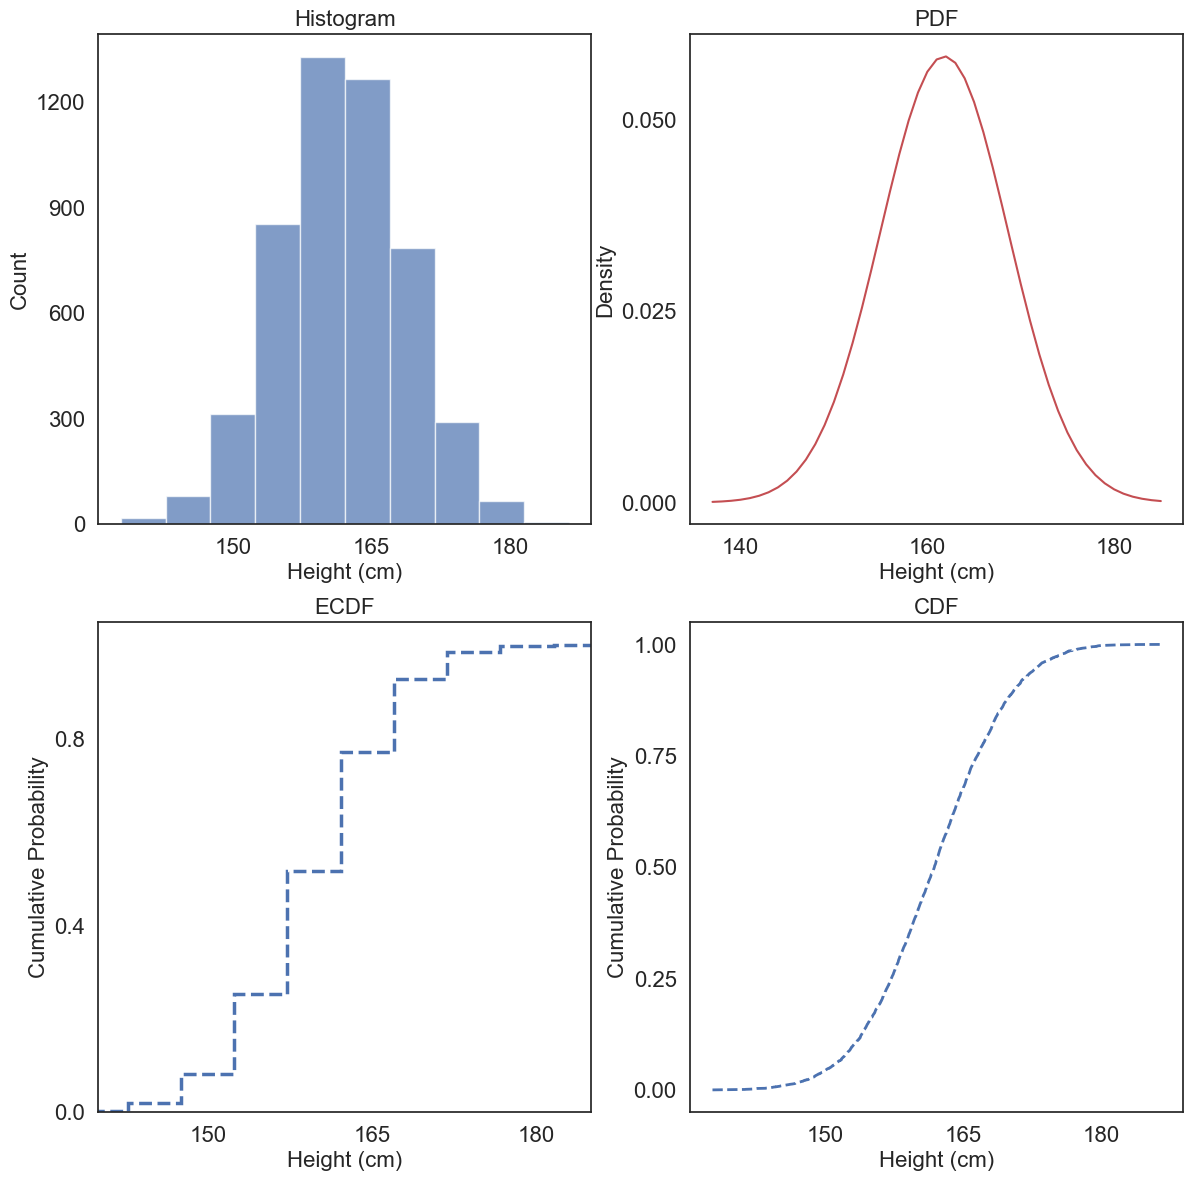

In [6]:
# Plot our sample distribution and the PDF we generated.
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)
ax3.tick_params(axis='both', which='major', labelsize=xlarge)
ax4.tick_params(axis='both', which='major', labelsize=xlarge)

# Raw data 
ax1.hist(heights, bins=10, alpha=0.7)
ax1.set_ylabel("Count", fontsize=xlarge)
ax1.set_xlabel("Height (cm)", fontsize=xlarge)
ax1.set_title('Histogram', fontsize=xxlarge)

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))

# PDF
ax2.plot(values, probabilities, color='r')
ax2.set_ylabel("Density", fontsize=xlarge)
ax2.set_xlabel("Height (cm)", fontsize=xlarge)
ax2.set_title('PDF', fontsize=xxlarge)

ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

# CDF
df['Height'].hist(ax=ax3, lw=2.5, linestyle='--', bins=10, cumulative=True, density=True, histtype='step')

ax3.grid(False)
ax3.set_title('ECDF', fontsize=xxlarge)
ax3.set_xlabel("Height (cm)", fontsize=xlarge)
ax3.set_ylabel("Cumulative Probability", fontsize=xlarge)
ax3.set_xlim([140, 185])

ax3.xaxis.set_major_locator(plt.MaxNLocator(3))
ax3.yaxis.set_major_locator(plt.MaxNLocator(3))

# ECDF 
x = heights 
cdf = ECDF(x)

x.sort()
F = cdf(x)

ax4.plot(x, F, linestyle='--', lw=2)

ax4.set_xlabel("Height (cm)", fontsize=xlarge)
ax4.set_title('CDF', fontsize=xxlarge)
ax4.set_ylabel("Cumulative Probability", fontsize=xlarge)

ax4.xaxis.set_major_locator(plt.MaxNLocator(5))
ax4.yaxis.set_major_locator(plt.MaxNLocator(5))

Figure 2.1: Histogram (top-left) and corresponding PDF (top-right), CDF (bottom-left) and ECDF (bottom-right) plots.

# PMF (Discrete variables)

In [7]:
dataset = pd.read_csv('./data/housing.csv')

dataset['bedrooms_to_rooms'] = dataset['total_rooms']/dataset['total_bedrooms']
dataset['households_to_population'] = dataset['population']/dataset['households']
dataset['per_capita_income'] = dataset['median_income']/dataset['population']
dataset['per_household_income'] = dataset['median_income']/dataset['households']

data = dataset['ocean_proximity'].value_counts()

# Improve visibility of this variable in plot
data['ISLAND']+=500
print(data.round(2).head())

ocean_proximity
LTH OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND         505
Name: count, dtype: int64


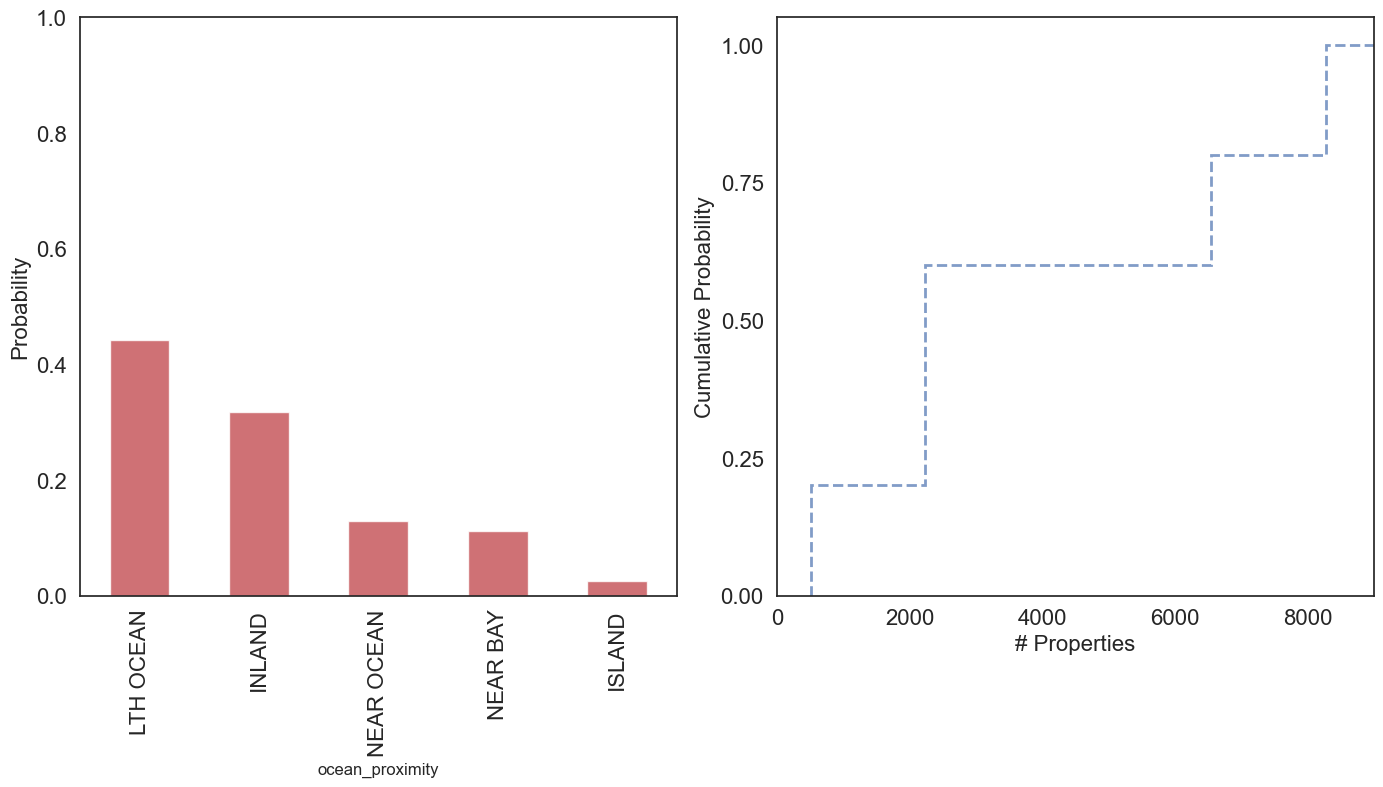

In [8]:
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))

# PMF 
pmf = data.sort_index() / len(dataset['ocean_proximity'])
pmf = pmf.sort_values(ascending=False)

pmf.plot(kind='bar', ax=ax1, color="r", alpha=0.8)

# CDF
ax2.hist(data, bins=10, density=True, cumulative=True, label='CDF', lw=2, linestyle="--", histtype='step', alpha=0.7)

ax1.set_ylabel("Probability", fontsize=xlarge)
ax1.set_ylim([0.0, 1.0])
ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))

ax2.set_ylabel("Cumulative Probability", fontsize=xlarge)
ax2.set_xlabel("# Properties", fontsize=xlarge)
ax2.set_xlim([0, 9000])

ax2.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()

## Kernel Density
**Example 2.2**. The data set in this example is based on the recorded flipper length (in millimetres) of 342 penguins captured and measured on the Palmer Archipelago (Antarctica); see Table 2.2. The data captures three different species of penguin, along with data on their location (island), bill length and depth, and flipper length in millimetres.

In [9]:
penguins = sns.load_dataset("penguins")
data = penguins

df = data["flipper_length_mm"].dropna()
print(data.head(6))

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  
5       3650.0    Male  


Table 2.2: Sample of the Palmer Archipelago (Antarctica) data set; the lengths are in millimetres.

Mean=200.915, Standard Deviation=14.041


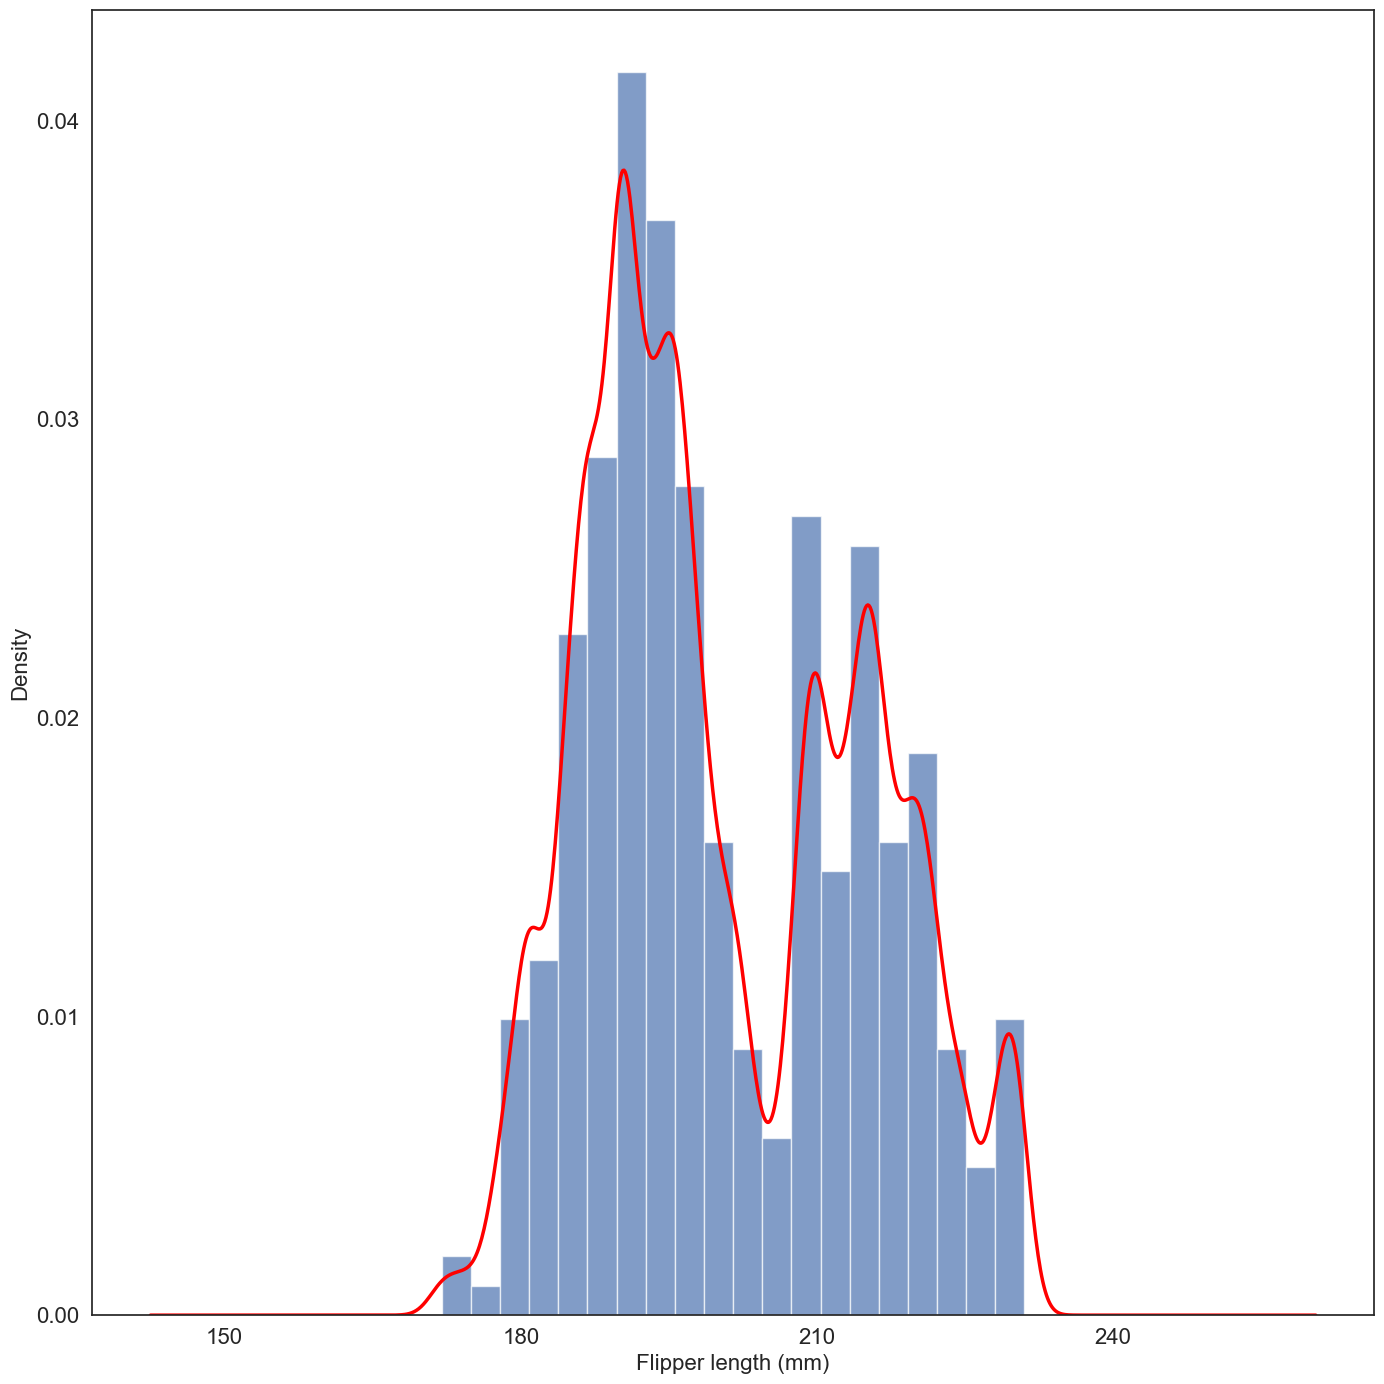

In [10]:
sample = df.tolist()
# calculate parameters

sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))

# define the distribution
dist = norm(sample_mean, sample_std)

# sample probabilities for a range of outcomes
values = [value for value in range(150,250)] # 100 experiment
probabilities = [dist.pdf(value) for value in values]

ax = df.hist(density=True, alpha=0.7, bins=20)

df.plot(kind = 'density', bw_method=0.1, color="red", lw=2.5)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.set_xlabel("Flipper length (mm)", fontsize=xlarge)
ax.set_ylabel("Density", fontsize=xlarge)
ax.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.2: The histogram for the flipper length of penguins from the Palmer Archipelago (Antarctica) data set, and the corresponding kde plot (overlaid in red).

# Bernoulli distribution
**Example 2.3**. Consider the USA election results for the main candidates for the USA Presidency in 2020, where Joe Biden received 81,281,888 votes, and Donald Trump 74,223,251 votes; see Table 2.3. A Bernoulli distribution is fitted to the data set through maximum likelihood, resulting in the model parameter p = 0.52 representing Biden’s winning proportion.

In [11]:
biden = 81.28 # Biden: 81,281,888 votes
trump = 74.22 # Trump: 74,223,251 votes
total = biden + trump

percent_biden = biden/total
percent_trump = 1 - percent_biden

# Plot Distribution
df = pd.DataFrame.from_dict({'Biden': biden, 'Trump': trump}, orient='index', columns=['Total vote'])
print(df.head())

       Total vote
Biden       81.28
Trump       74.22


Table 2.3: The total number (#) of votes (in millions) received by Biden and Trump in the USA 2020 Presidential elections.


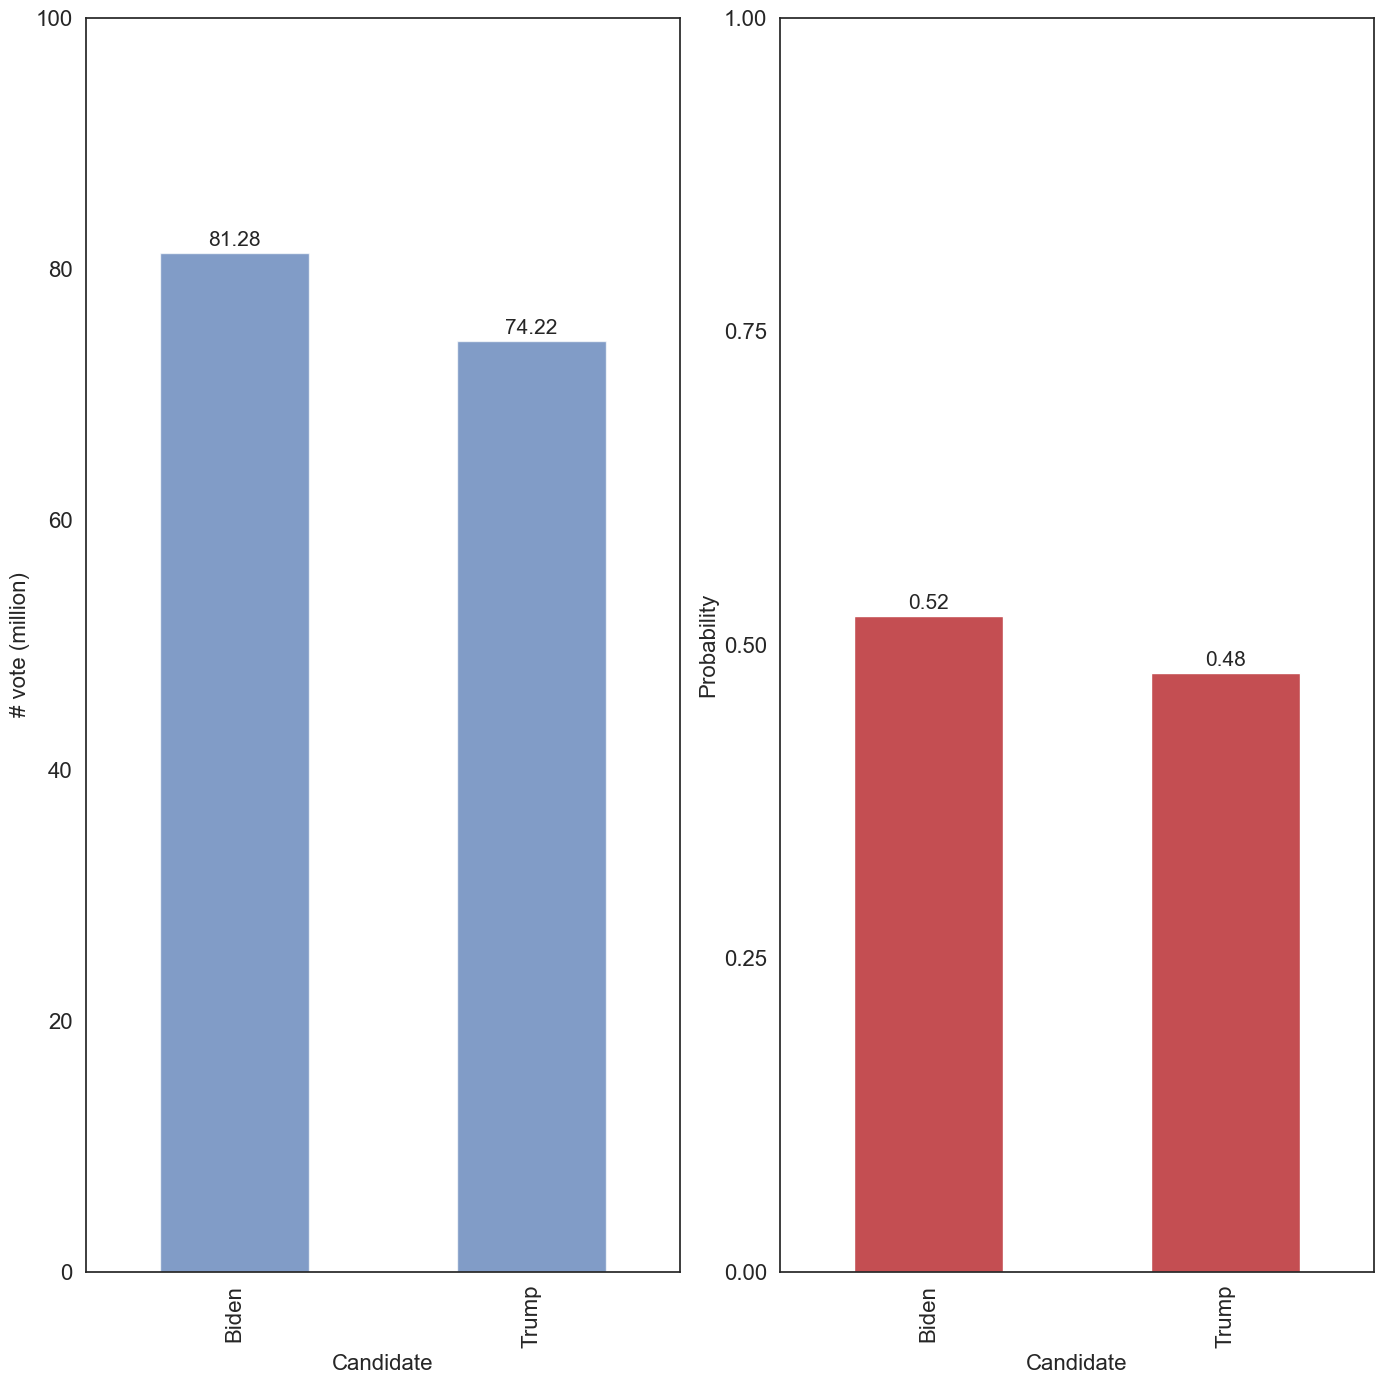

In [12]:
# Plot our sample distribution and the PDF we generated.
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

# Plot raw data 
df.plot(kind="bar", ax=ax1, legend=False, alpha=0.7)

ax1.set_ylabel("# vote (million)", fontsize=xlarge)
ax1.set_xlabel("Candidate", fontsize=xlarge)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=15,
                   xytext = (0, 9), 
                   textcoords = 'offset points')

ax1.set_ylim(0, 100)

# PMF
x = [0,1]

# Find the statistical parameters
prob = percent_biden
mean, var, skew, kurt = bernoulli.stats(prob, moments='mvsk')

p_trump, p_biden = bernoulli.pmf(x, prob)

df_pmf = pd.DataFrame.from_dict({'Biden': p_biden, 'Trump': p_trump}, columns=['Vote'], orient='index')

df_pmf.plot(kind="bar", color=["r","b"], ax=ax2, legend=False)

for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontsize=15)

ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel("Candidate", fontsize=xlarge)
ax2.set_ylabel("Probability", fontsize=xlarge)

ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.3: The histogram (left) and the corresponding PMF (right), for the proportion of candidate votes for each candidate. It is worth noting that the PMF is a scaled version of the histogram. A Bernoulli distribution with p = 0.52 is fitted to the data. That is, X ∼ Bern(0.52), where X is a random variable indicating whether a vote will be counted for Biden rather than Trump. 

# Binomial distribution



**Example 2.4.** Consider data generated from 100 repeated experiments, where each experiment consists of n = 100 tosses (i.e. 100 trials) of an unbiased coin (i.e. p = 0.5). A binomial distribution, assuming n = 100, is fitted to the data set through maximum likelihood, resulting in the model parameter p = 0.5 representing the number of heads in 100 trials. That is, X ∼ Bin(100, 0.5), where X is a random variable indicating the number of heads obtained during the 100 trials.

In [13]:
# trials n=trials how many times you toss it (1000 times), experiments number of times you run those trials n=100
n = 100
p = .5

binomial = binom(n, p)

binomial_sample=binomial.rvs(size=1000,random_state=143)
t = np.arange(0, n)

print(pd.Series(binomial_sample).round(2).head())


0    42
1    51
2    52
3    49
4    48
dtype: int64


Table 2.4: Sample results of the first five experiments for a binomial distribution with p = 0.5 and n = 100. 

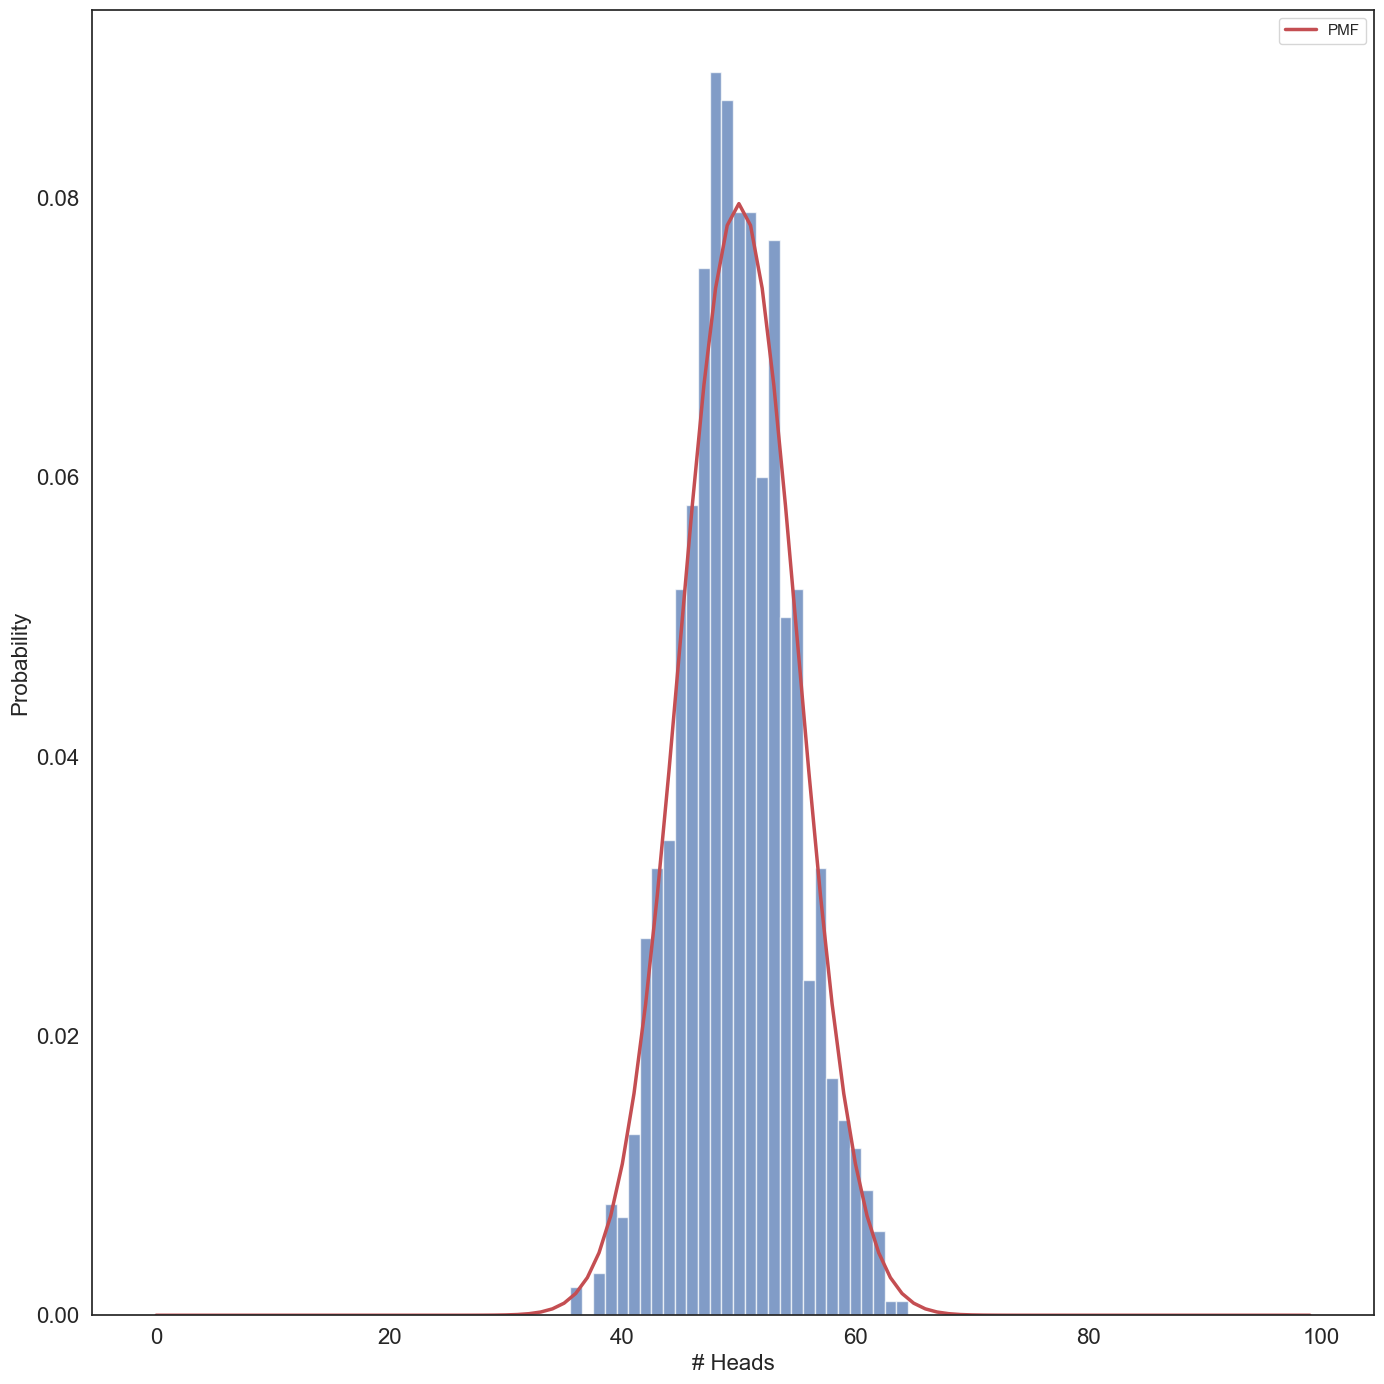

In [14]:
plt.hist(binomial_sample, bins=100,range=(0,100),density=True,align='left', alpha=0.7)
plt.plot(t, binomial.pmf(t),color="r", lw=2.5, label="PMF")

plt.xlabel("# Heads", fontsize=xlarge)
plt.ylabel("Probability", fontsize=xlarge)
plt.tick_params(axis='both', which='major', labelsize=xlarge)
plt.legend()

plt.tight_layout()

Figure 2.4: The histogram and the corresponding PMF (overlaid in red) for the proportion of resulting headss; a Binomial distribution with p = 0.5 and n = 100 is fitted to th 
data, that is, X ∼ Bin(100, 0.5.


# Normal/Gaussian distribution
**Example 2.6**. Consider the heights of women recorded in a telephone survey in the United States in 1990; see Table 2.1 (reproduced above). A normal distribution is fitted to the data set through maximum likelihood, resulting in the model parameters µ = 161.820 and σ = 6.848. That is, X ∼ N(161.820, 6.848), where X is a random variable indicating the height of a woman in the 1990 telephone survey. y

In [15]:
df = pd.read_csv('./data/weight-height.csv', delimiter="\t")
df = df[df['Gender']=='Female']
df['Height'] = df['Height'] * 2.54

# Calculate mean and standard deviations as we need them to generate a normal distribution.
sample = df['Height'].tolist()

# calculate the parameters
sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))

# define the distribution
dist = norm(sample_mean, sample_std)

# sample probabilities for a range of outcomes
values = [value for value in range(135, 190)]
probabilities = [dist.pdf(value) for value in values]

print(df.round(2).head())

Mean=161.820, Standard Deviation=6.848
      Gender  Weight  Height
5000  Female  102.09  149.63
5001  Female  141.31  165.68
5002  Female  131.04  160.96
5003  Female  128.17  163.78
5004  Female  129.78  156.95


Table 2.1: A sample of the data for height (in centimeters) and weight (in kilograms), of American women, recorded in a telephone survey in 1990

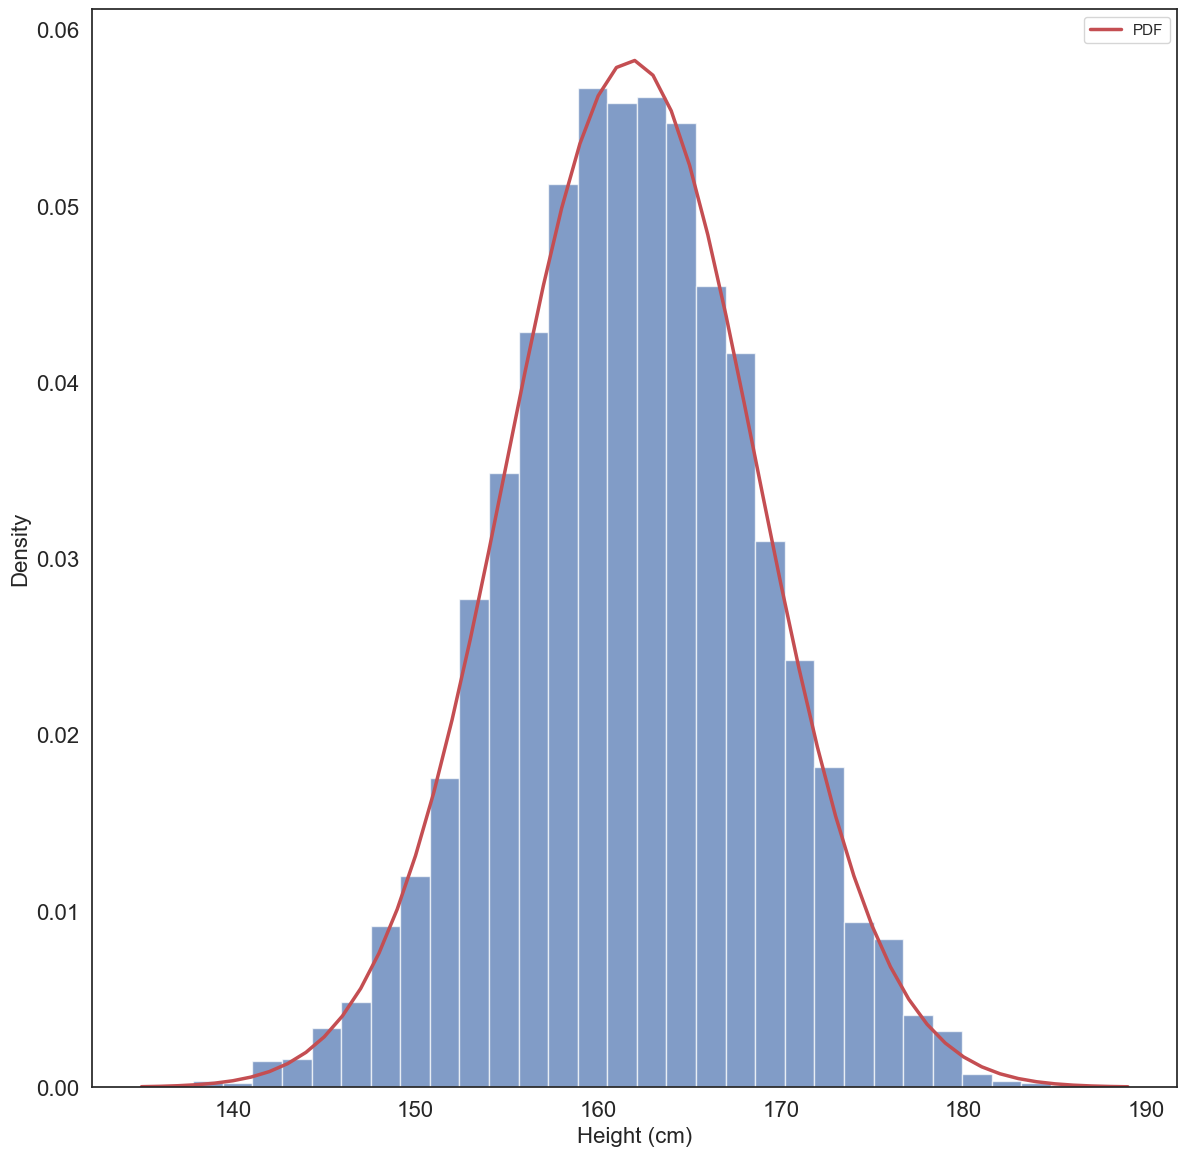

In [16]:
# plot the histogram and pdf
plt.hist(sample, bins=30, density=True, alpha=0.7)
plt.plot(values, probabilities, color='r', lw=2.5, label="PDF")

plt.xlabel('Height (cm)', fontsize=xlarge)
plt.ylabel('Density', fontsize=xlarge)
plt.tick_params(axis='both', which='major', labelsize=xlarge)
plt.legend()

Figure 2.6: Histogram and PDF (overlaid in red) of the distribution of the 
heights of women; a normal distribution with parameters µ = 63.709 an 
σ = 2.696 is fitted to the data, X ∼ N(63.709, 2.696).


# Exponential distribution
**Example 2.7**: Consider two data sets, one recording the survival time in days after a heart transplant from a 1967-1974 study of 304 individuals (see
Table 2.6), and the second recording the inter-arrival time of approximately 550,000 posts published on HackerNews between 2006 and late 2017 (see Table 2.7). Exponential distribution are fitted to both data sets through maximum likelihood, resulting in the model parameters λ = 223.28 for the first data set representing the survival rate in days after a heart transplant, and λ = 0.99 for the second data set representing the rate in seconds before a new post arrives. That is, X ~ Exp(223.28), where X is a random variable indicating the survival time in days after a heart transplant, and
X ∼ Exp(0.99), where X is a random variable indicating the inter-arrival time in seconds of HackerNews posts. The histograms and the PDFs (overlaid in red) for the probability of survival after a heart attack (left) and for the arrival of a HackerNews post (right), are shown in Figure 2.7.

In [17]:
data = statsmodels.datasets.heart.load_pandas().data
data = data[data.censors == 1]

sample = data.survival
smean = sample.mean()
s_std = std(sample)

# define the distribution
dist = norm(smean, s_std)
rate = 1. / smean
nbins = 9
smax = sample.max()
x = np.linspace(expon.ppf(0.01), expon.ppf(0.99), 1500)

# sample probabilities for a range of outcomes
values = [value for value in range(0, 1500)]
probabilities = expon.pdf(values, scale=1. / rate)

loc, scale = expon.fit(sample, floc=0)

print(data[:10])
print("params", loc, scale)

   survival  censors   age
0      15.0      1.0  54.3
1       3.0      1.0  40.4
2     624.0      1.0  51.0
3      46.0      1.0  42.5
4     127.0      1.0  48.0
5      64.0      1.0  54.6
6    1350.0      1.0  54.1
7     280.0      1.0  49.5
8      23.0      1.0  56.9
9      10.0      1.0  55.3
params 0.0 223.2888888888889


Table 2.6: One dataset records the survival time in days after a heart transplant from a 1967-1974 study of 304 individuals. This sample of data shows the heart transplant survival rates of individuals, 
measured in days alongside the age of the individual.

In [18]:
# Load hackernews post data set
df_hn = pd.read_csv('./data/hn_scores.csv', index_col=0)
df_hn = df_hn.sort_values('time').reset_index(drop=True)
df_hn["delta_s"]=df_hn.time.diff()
df_hn = df_hn.dropna()

outlier_max=800
story_rate = 1/(df_hn.delta_s[df_hn.delta_s < outlier_max].mean()) # 1/100 sec
print(df_hn.head())

sample = df_hn.delta_s[df_hn.delta_s < outlier_max]
smean = sample.mean()
s_std = std(sample)

# define the distribution
dist = norm(smean, s_std)
loc, scale = expon.fit(sample, floc=0)
print("params", loc, scale)

rate = 1. / smean
nbins = 30
smax = sample.max()
x = np.linspace(expon.ppf(0.01), expon.ppf(0.99), outlier_max)

# sample probabilities for a range of outcomes
values = [value for value in range(0, outlier_max)]
probabilities = expon.pdf(values, scale=1. / rate)

print(df_hn.head())
print("params", loc, scale)

   score     author        time  delta_s
1      1  cthackers  1387536536    106.0
2      1   lecowski  1387536593     57.0
3      1   brianchu  1387536759    166.0
4      3       rb2e  1387536769     10.0
5      0  finerolla  1387537034    265.0
params 0.0 99.10187020425414
   score     author        time  delta_s
1      1  cthackers  1387536536    106.0
2      1   lecowski  1387536593     57.0
3      1   brianchu  1387536759    166.0
4      3       rb2e  1387536769     10.0
5      0  finerolla  1387537034    265.0
params 0.0 99.10187020425414


Table 2.7: The second dataset records the inter-arrival time of approximately 550,000 posts published on HackerNews between 2006 and late 2017. This sample of data shows the post data received on HackerNews, with postage 
timestamp and inter-arrival time in seconds.

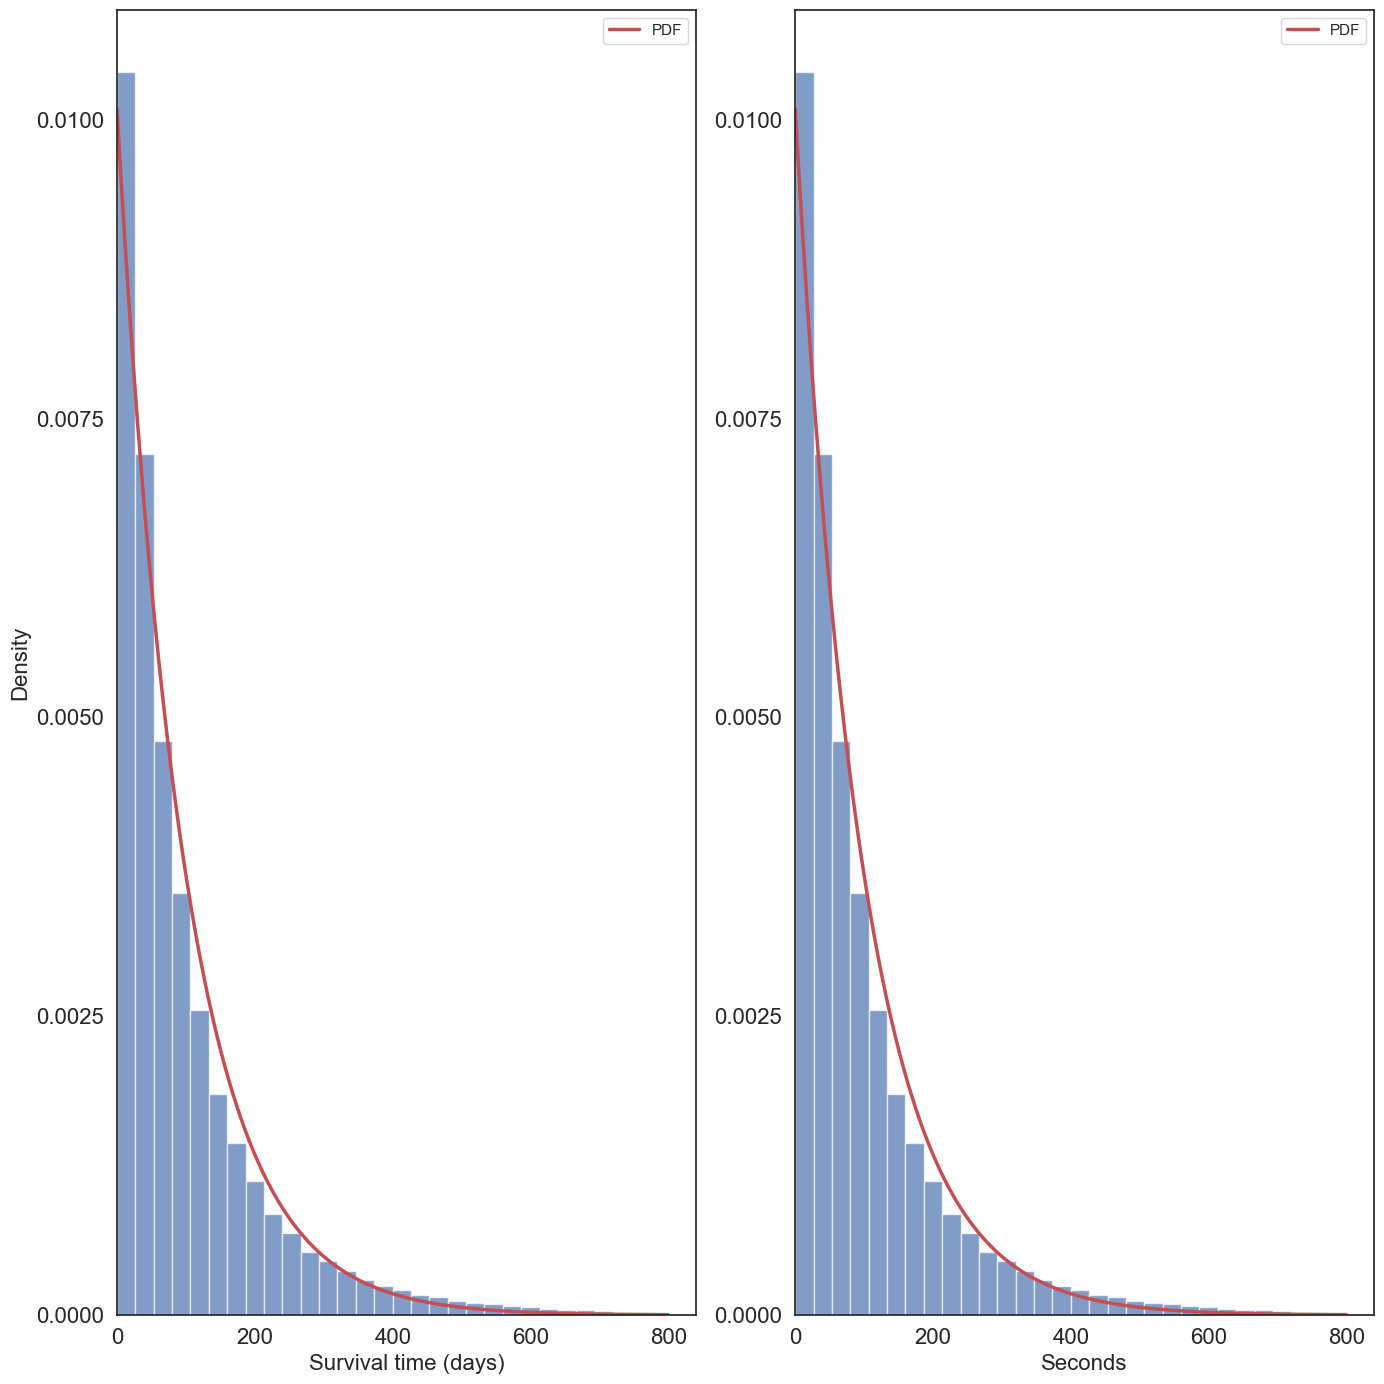

In [19]:
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

sample.hist(bins=nbins, density=True, ax=ax1, alpha=0.7)
ax1.plot(values, probabilities, 'r-', lw=2.5, label='expon pdf')
ax1.legend(['PDF'])
ax1.set_xlim(left=0)

ax1.set_xlabel("Survival time (days)", fontsize=xlarge)
ax1.set_ylabel("Density", fontsize=xlarge)

ax1.grid(False)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

sample.hist(bins=nbins, density=True, ax=ax2, alpha=0.7)
ax2.plot(values, probabilities, 'r-', lw=2.5, label='PDF')

plt.xlim(left=0)

ax2.set_xlabel("Seconds", fontsize=xlarge);
ax2.legend(loc='upper right')
ax2.grid(False)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.7: Histograms and PDFs (overlaid in red) of heart surgery survival 
rates (left), and HackerNews posts (right); an exponential distribution with
λ = 223.28 is fitted to the heart data, that is, X ∼ Exp(222.28), while  n
exponential distribution with λ = 0.99 is fitted to the HackerNews da a,
that is, X ∼ Exp(0.9).
).


# Pareto distribution
**Example 2.8**: Consider two data sets, one recording the salaries of football players from FIFA 2019 (see Table 2.8), and the second recording the counts of words in the Brown corpus (see Table 2.9). A Pareto distribution is fitted to both data sets through maximum likelihood, resulting in the scale and shape parameters xm = 2.46 and α = 0.13, respectively, for the first data set representing the salaries of football player, and the scale and shape parameters x_m = 72.192 and α = 1.0435, respectively, for the second data set representing the counts of words. That is, X ∼ Pareto(2.46, 0.13), where X is a random variable indicating the salary of a football player, and X ∼ Pareto(72.192, 1.0435), where X is a random variable indicating the count of a word, respectively. The histograms and the PDFs (overlaid in red) for the probability of a salary of a football player (left) and for the count of a word (right), are shown in Figure 2.8.re 2.8.is
2.8.is


In [20]:
new_data = pd.read_csv('./data/fifa_salaries.csv') 
print(new_data.head())

nbins1 = 100
outlier_max1=2000

sample1 = new_data['salary'].to_list()

# distribution fitting
alpha, loc, scale = pareto.fit(sample1) 
x1 = np.linspace(0,100000, 18200)
print("alpha",alpha, "loc", loc, "scale", scale)

# fitted distribution
pdf_fitted1 = pareto.pdf(x1, b=alpha, loc=loc, scale=scale)

   idx  salary
0  276    1000
1  286    1000
2  288    1000
3  301    1000
4  381    1000
alpha 129519033.04880124 loc -1099511626775.9995 scale 1099511627775.9994


Table 2.8: Sample of FIFA 2019 data showing the salary information in Euros for each player with the top-20 removed.

In [21]:
# Load second dataset
text = brown.words(categories=['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies',
'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance',
'science_fiction'])
print(text)

outlier_max2 = 1500
fdist = nltk.FreqDist(w.lower() for w in text).most_common(outlier_max2)

## Conversion to Pandas series via Python Dictionary for easier plotting
sample2 = pd.Series(dict(fdist)).to_list()
nbins2 = 800
x2 = np.linspace(0, outlier_max2, 100)

# distribution fitting
alpha, loc, scale = pareto.fit(sample2) 
print("alpha", alpha, "loc", loc, "scale", scale)

# fitted distribution
pdf_fitted2 = pareto.pdf(x2, b=alpha, loc=loc, scale=scale)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]
alpha 1.0063534158922778 loc 4.801778232705587 scale 67.1982217672944


Table 2.9: Sample of data representing the total count of each word in the Brown corpus.

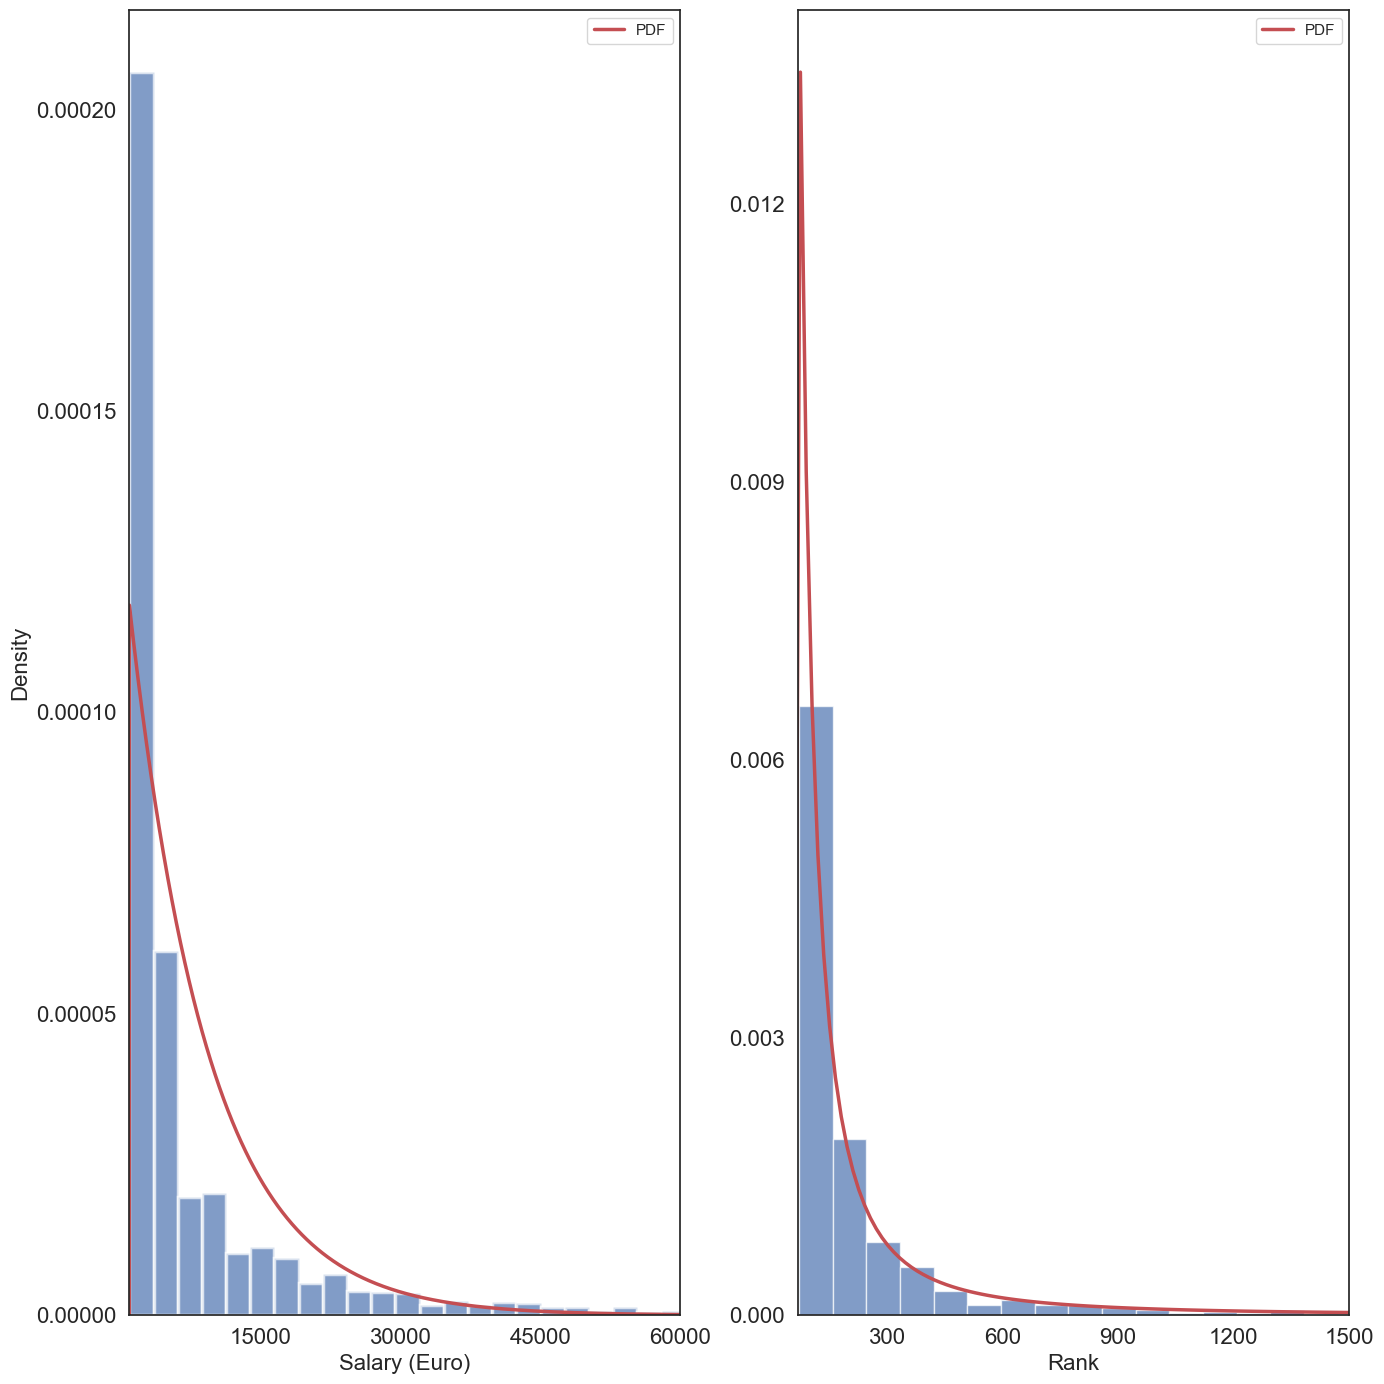

In [22]:
# Plot both data
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

ax1.hist(sample1, bins=nbins1, color='b', density=True, linewidth=2.5, alpha=0.7, label=None)
ax1.plot(x1 , pdf_fitted1,'r-', lw=2.5, label="PDF")

ax1.set_xlim([1000, 60000])

ax1.set_xlabel('Salary (Euro)', fontsize=xlarge)
ax1.set_ylabel('Density', fontsize=xlarge)
ax1.legend()

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

ax2.hist(sample2, bins= nbins2,density=True, alpha=0.7)
ax2.plot(x2, pdf_fitted2,'r-', lw=2.5, label="PDF")

ax2.set_xlim([70, outlier_max2])
ax2.set_xlabel('Rank', fontsize=xlarge)
ax2.legend()

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.8: Histogram plot of FIFA 2019 player salaries (left), and a further plot of the top 1500 words and their frequency counts in the Brown corpus 
(right); a Pareto distribution with parameters$ _{x}m = 2.4$6 and$\alphaα = 0 $ 
is fitted to the football salary data, that i$s X ∼ Pareto(2.46, 0.1$3), ih  e
a Pareto distribution wi$t_{h} xm = 72.$192 a$\alphad α = 1.0$435 is fitted to  he
word count data, that$ is X ∼ Pareto(72.192, 10$435), where X isaa r  dom
variable indicating the count of a word in othe cpus.


# Poisson distribution
**Example 2.5**: Consider the count of births per hour in a single 24-hour period at a hospital in Brisbane, Australia; see Table 2.5. The data appeared originally in the Brisbane-based newspaper "The Sunday Mail" on 21st December in 1997. A Poisson distribution is fitted to the data set through a maximum likelihood, resulting in the model parameter $\lambda = 2.01$ representing the mean number of births, and its variance, within an interval of an 
hour. That s $X ~∼ Pois(2.01$), where$ $X is a random variable indicaing th  
number of births within a period of an hour. The histogram and thP   F
(overlaid in red) for the probability of the number of births occrnriiith   in
an hour, are shown in Figure 2.5.

In [23]:
model = poisson(mu=2)
poisson_sample = model.rvs(size=1000,random_state=143)
# e-lambda
end = np.max(poisson_sample)+1
x=np.arange(0,end)

df = pd.read_csv('./data/babyboom.csv')
temp = {}

for k, v in df['hour'].items():
    #print(k, v)
    temp.setdefault(v, 0)
    temp[v] += 1


psn = poisson(mu=2)
end2 = np.max(sample)

sample = [temp[hour] for hour in temp.keys()]
sample = psn.rvs(size=1000, random_state=143)

x = np.arange(0, end2)
y = psn.pmf(x)

smoothing = interpolate.make_interp_spline(x, y)
x_new = np.linspace(0, 8, 300)
y_new = smoothing(x_new)

print(df.head())

   hour   time  gender  Birth weight (grams)  mins after midnight
0     0  00:05       1                  3837                    5
1     1  01:04       1                  3334                   64
2     1  01:18       2                  3554                   78
3     1  01:55       2                  3838                  115
4     2  02:57       2                  3625                  177


Table 2.5: Sample data of the number of births recorded each hour on a 
single ward and day.

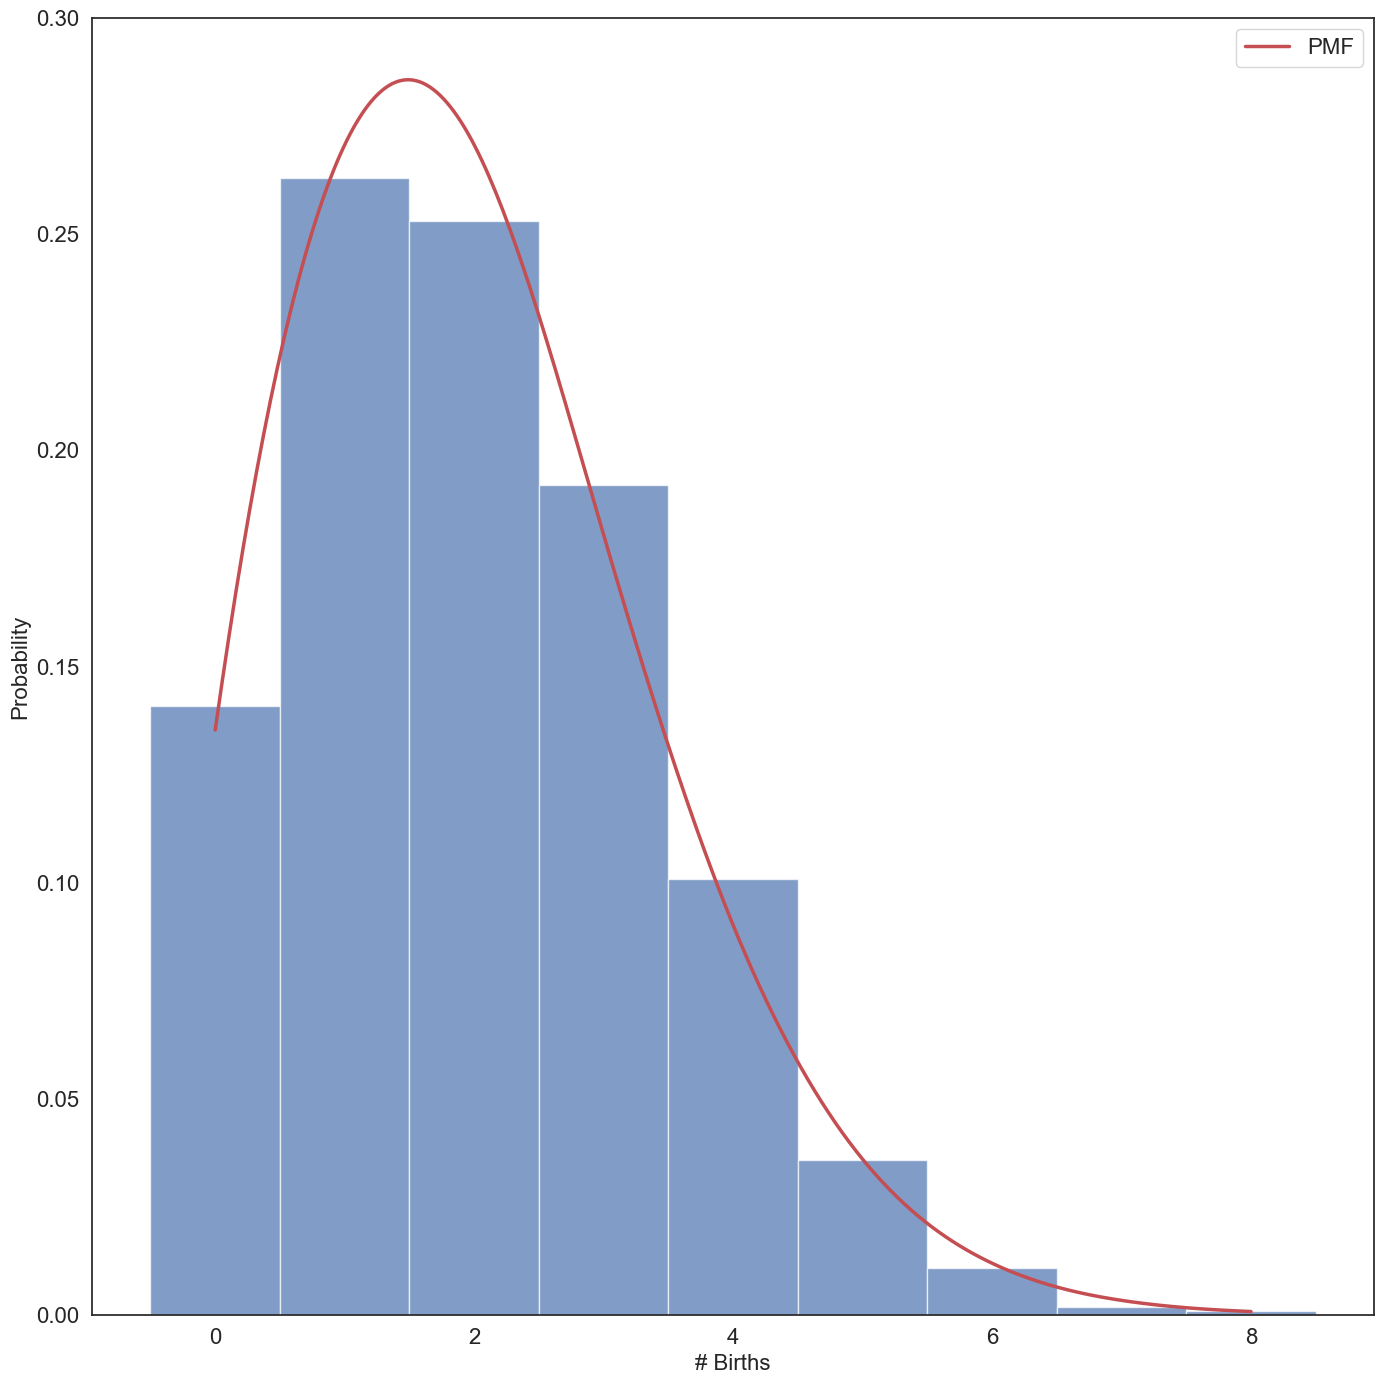

In [24]:
ax1 = plt.subplot2grid((1,1), (0,0))
plt.hist(sample, bins=end, range=(0, end), density=True, align='left', alpha=0.7)

plt.ylabel("Probability", fontsize=xlarge)
plt.xlabel("# Births", fontsize=xlarge)

plt.plot(x_new, y_new, color="r", label="PMF", lw=2.5)
plt.legend(['PMF'], fontsize=xlarge)

#ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

ax1.set_ylim(0,0.3)

plt.tight_layout()

Figure 2.5: Histogram and PMF (overlaid in red) for the number of births within a period of an hour; a Poisson distribution with λ = 2.01 is fitted to the data, that is, X ∼ Pois(2.01).

# Statistics of samples
**Example 2.9**: A boxplot visualisation summarising the salaries of different 
educational backgrounds for 5000 individuals recorded by a survey run by 
a popular programming peer support web site (see Table 2.10), is shown  n
Figure 2 9.
The height of the box in the boxplot is the difference between the t ird
(75th percentile) and first (25th percentile) quartiles, called the interqua tile
range (IQR). The median is represented by a horizontal line across eac  box,
and can be supplement with further statistics, such as the mean  shown
here as a white dot. In addition, each boxplot displays the minim m value
(bottom whisker) and maximum value (top whisker).

In [25]:
data_url = "./data/StackOverflow_survey_filtered_subsampled_2019.csv"
data = pd.read_csv(data_url)
print(data.head())

# Filter some of the roles and remove any outliers
data=data.query('Manager=="IC"')
data=data.query('CompTotal<300000 & CompTotal>30000')

   CompTotal Gender Manager YearsCode Age1stCode YearsCodePro Education
0   180000.0    Man      IC        25         17           20        MA
1    55000.0    Man      IC         5         18            3        BA
2    77000.0    Man      IC         6         19            2        BA
3    67017.0    Man      IC         4         20            1        BA
4    90000.0    Man      IC         6         26            4     LT BA


Table 2.10: Sample of data from a popular programming peer support web site survey data set on salary (in US dollars) compared to highest qualification (LT stands for Less Than, MA - Masters degree, BA - Bachelors degree in any subject).

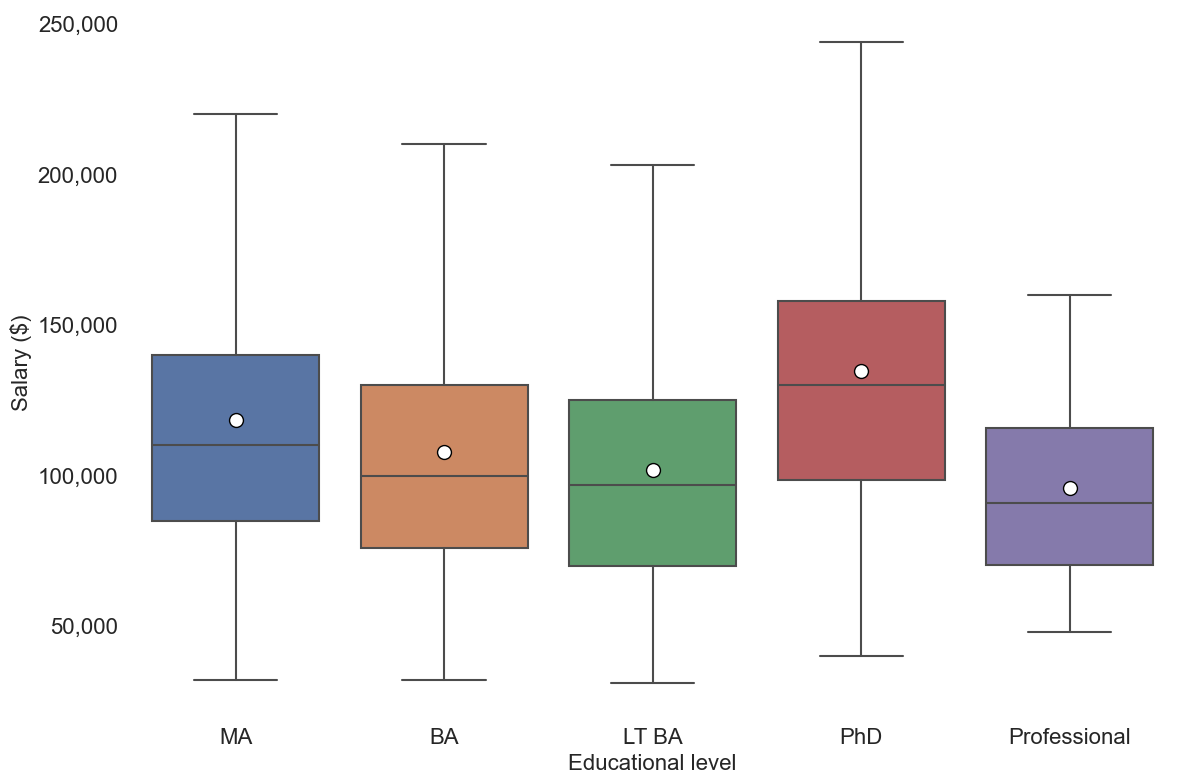

In [26]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="Education", 
            y="CompTotal", 
            data=data,    
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
            showfliers=False)


sns.despine(left=True, bottom=True)

plt.ylabel("Salary ($)", fontsize=xlarge)
plt.xlabel("Educational level", fontsize=xlarge)
ax.tick_params(axis='both', which='major', labelsize=xlarge)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.tight_layout()

Figure 2.9: Boxplot of the salary and qualification data set.

# Bootstrap (mean, median, mode)
**Example 2.10**: We carried out a bootstrap computation of the heights of 
women recorded in a telephone survey in the United States in 1990; se 
Table 2.1. In particular, 10,000 resamples of the data were generated wi h
replacement, to compute 95% confidence intervals for the mean, median  nd
mode of the data; the results are shown in Figure 2.10..9.

In [27]:
# Convert values from lb to kg, and cm to inches
def lbtokg(pounds):
    return pounds * 0.453592
    
def inchtocm(inches):
    centi_meters = inches * 2.54
    return round(centi_meters,2)

# Draw the samples for each bootstrap
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    return bs_replicates


df = pd.read_csv('./data/weight-height.csv', delimiter="\t")
data = df[df['Gender']=='Female']
print(data.head())
      
data["Weight"] = lbtokg(data["Weight"])
data["Height"] = inchtocm(data["Height"])

n = 500
nsamples = 10000
# Extract 500 random heights
heights = data['Height'].sample(n).reset_index(drop=True)

# Display Summary Statistics of heights in cm
display(heights.describe())

# Mean - Draw 15000 bootstrap replicates
bs_replicates_heights_mean = draw_bs_replicates(heights, np.mean, nsamples)
# Print empirical mean
print("Empirical mean: " + str(heights.mean()))
# Print the mean of bootstrap replicates
print("Bootstrap mean: " + str(np.mean(bs_replicates_heights_mean)))
# Get the corresponding values of 2.5th and 97.5th percentiles
conf_interval_mean = np.percentile(bs_replicates_heights_mean,[2.5,97.5])

# Median - Draw 15000 bootstrap replicates
bs_replicates_heights_median = draw_bs_replicates(heights, np.median, nsamples)
# Print empirical median
print("Empirical median: " + str(heights.median()))
# Print the mean of bootstrap replicates
print("Bootstrap median: " + str(np.median(bs_replicates_heights_median)))
conf_interval_median = np.percentile(bs_replicates_heights_median,[2.5,97.5])

# Mode - Draw 15000 bootstrap replicates
bs_replicates_heights_mode = draw_bs_replicates(heights, stats.mode, nsamples)
# Print empirical mode
print("Empirical mode: " + str(heights.mode()))
# Print the mean of bootstrap replicates
print("Bootstrap mode: " + str(stats.mode(bs_replicates_heights_mode)))
conf_interval_mode = np.percentile(bs_replicates_heights_mode, [2.5,97.5])


      Gender      Weight     Height
5000  Female  102.088326  58.910732
5001  Female  141.305823  65.230013
5002  Female  131.041403  63.369004
5003  Female  128.171511  64.479997
5004  Female  129.781407  61.793096


count    500.000000
mean     162.030840
std        7.151595
min      142.410000
25%      157.015000
50%      161.465000
75%      167.662500
max      179.680000
Name: Height, dtype: float64

Empirical mean: 162.03084
Bootstrap mean: 162.02709128400002
Empirical median: 161.465
Bootstrap median: 161.465
Empirical mode: 0    162.72
1    171.23
Name: Height, dtype: float64
Bootstrap mode: 171.23


Table 2.1: A sample of the data for height (in centimeters) and weight (in kilograms), of American women, recorded in a telephone survey in 1990.t).

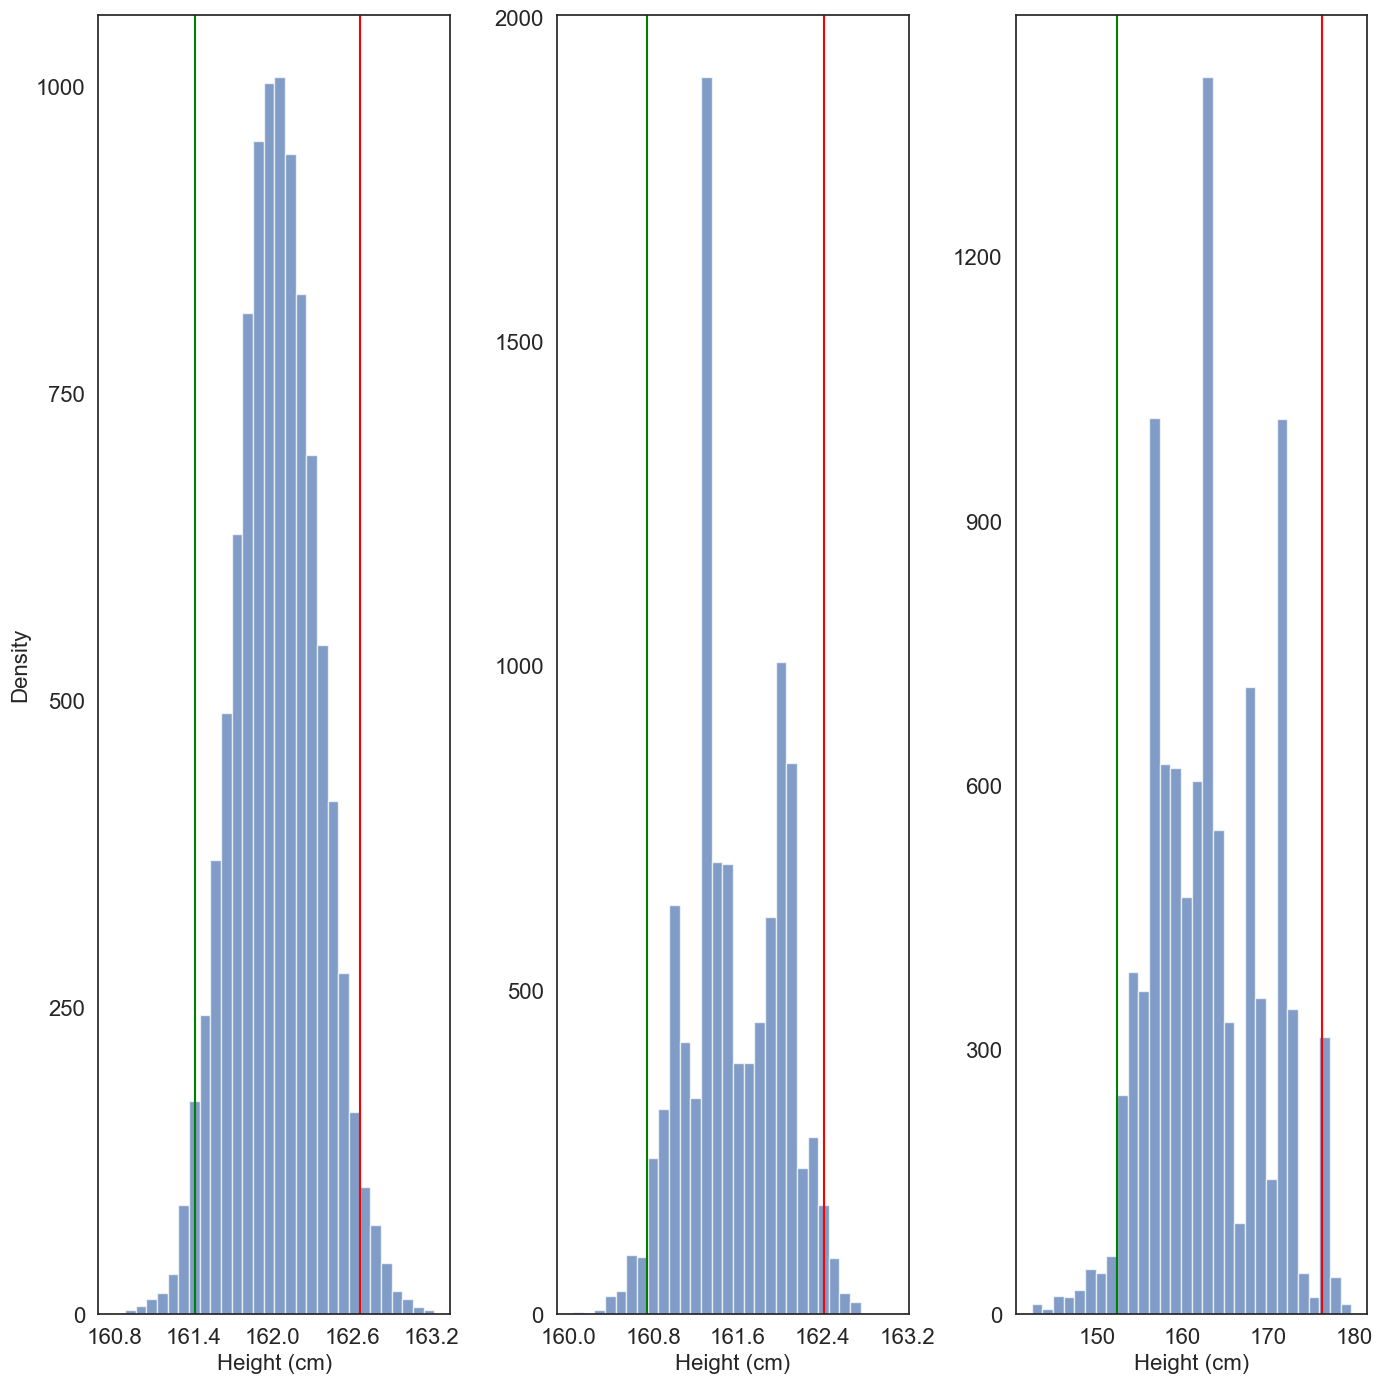

In [28]:
# Plot all bootstrap replicates and confidence intervals
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

# Plot the mean for bootstrap replicates as histogram
ax1.hist(bs_replicates_heights_mean,bins=30, alpha=0.7)

# Plot the median for bootstrap replicates as histogram
ax2.hist(bs_replicates_heights_median,bins=30, alpha=0.7)

# Plot the mode for bootstrap replicates as histogram
ax3.hist(bs_replicates_heights_mode, bins=30, alpha=0.7)

# Showing the related percentiles
ax1.axvline(x=np.percentile(bs_replicates_heights_mean, [2.5]), ymin=0, ymax=1, c='green')
ax1.axvline(x=np.percentile(bs_replicates_heights_mean, [97.5]), ymin=0, ymax=1, c='red')
ax1.set_xlabel("Height (cm)", fontsize=xlarge)
ax1.set_ylabel("Density", fontsize=xlarge)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major', labelsize=xlarge)
#ax1.set_ylim([0, 1800])

# Showing the related percentiles
ax2.axvline(x=np.percentile(bs_replicates_heights_median, [2.5]), ymin=0, ymax=1, c='green')
ax2.axvline(x=np.percentile(bs_replicates_heights_median, [97.5]), ymin=0, ymax=1, c='red')
ax2.set_xlabel("Height (cm)", fontsize=xlarge)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.tick_params(axis='both', which='major', labelsize=xlarge)
#ax2.set_ylim([0, 1800])

# Showing the related percentiles
ax3.axvline(x=np.percentile(bs_replicates_heights_mode, [2.5]), ymin=0, ymax=1, c='green')
ax3.axvline(x=np.percentile(bs_replicates_heights_mode, [97.5]), ymin=0, ymax=1, c='red')
ax3.set_xlabel("Height (cm)", fontsize=xlarge)
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
ax3.tick_params(axis='both', which='major', labelsize=xlarge)
#ax3.set_ylim([0, 1800])

plt.tight_layout()

Figure 2.10: PDF for the bootstrap computation of 95% confidence intervals for the mean (left), median (middle), and mode (right) of the heights of women in the telephone survey data set.

# Confidence intervals
**Example 2.11**: Consider the number of passengers recorded on flights on a monthly period from 2002 to 2020 departing from USA airports on international flights; see Table 2.11. Now, a line plot a series of points are joined by straight line fragments. A line plot of the number of passengers on a yearly basis data, together with 95% confidence intervals for the mean and median are shown in Figure 2.11. The confidence intervals are computed from a bootstrap of 10,000 resamples of the passenger data over the months of each year.ar.i

In [29]:
flights = pd.read_csv('./data/flight_data.csv')
print(flights.head())

   Year  Month  Domestic  International     Total
0  2002     10  48054917        9578435  57633352
1  2002     11  44850246        9016535  53866781
2  2002     12  49684353       10038794  59723147
3  2003      1  43032450        9726436  52758886
4  2003      2  41166780        8283372  49450152


Table 2.11: Sample of data recording the flights and passenger counts on a monthly basis for international flights leaving USA airports on international
flights ($#$ denotes the number of passengers).

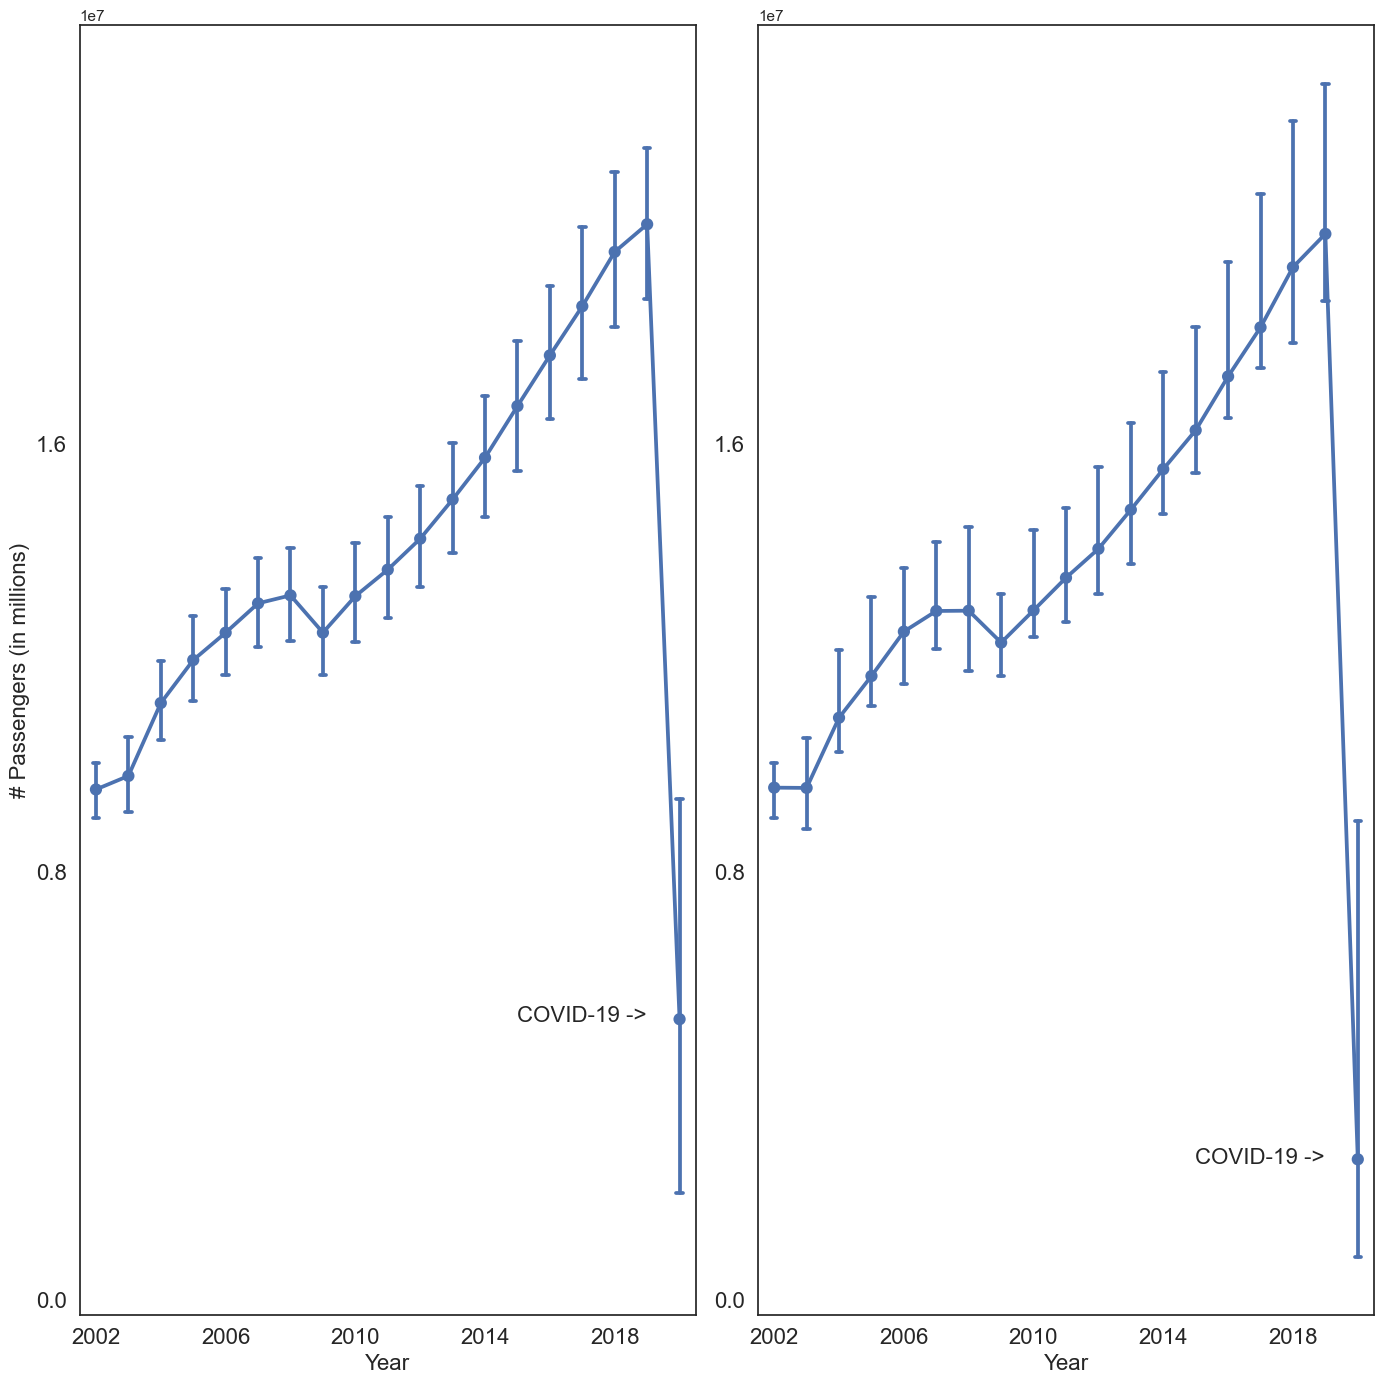

In [30]:
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1), sharey=ax1)

sns.pointplot(data=flights, x="Year", y="International", capsize=.2, estimator=np.mean, ci=97.5, n_boot=10000, ax=ax1)
ax1.set_xlabel('Year', fontsize=xlarge)
ax1.set_ylabel('# Passengers (in millions)', fontsize=xlarge)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.annotate(r'COVID-19 ->',
            xy=(1, 8), xycoords='data',
            xytext=(0.92, 0.24), textcoords='axes fraction', fontsize=16,
            horizontalalignment='right', verticalalignment='top')
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

sns.pointplot(data=flights, x="Year", y="International", capsize=.2, estimator=np.median, ci=97.5, n_boot=10000, ax=ax2)
ax2.set_xlabel('Year', fontsize=xlarge)
ax2.set_ylabel('')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.annotate(r'COVID-19 ->',
            xy=(1, 4), xycoords='data',
            xytext=(0.92, 0.13), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', fontsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.11: Two line plots with the mean number of passengers (left), and median number of passengers (right) on international flights leaving the U.S. The band represents the confidence intervals of the 2.5th and 97.5th
percentiles computed from the monthly passenger count for each year.

# Skewness and kurtosis


## Negative skew
Example 2.13. Consider a data set recording the age at death of notable individuals in 2016; see Table 2.13. This data set is composed of 6,839 notable
deaths in 2016 published on a monthly basis on Wikipedia, and includes, fo 
each individual, the name, age and reason for notability. In Figure 2.13 the
histogram of the data set is shown, together with the PDF (overlaid in r d)
of a normal distribution with the same mean and standard deviation as the
original data set. It can be seen that the data set is negatively skewed.

In [31]:
# A function to get a list of death dates from wikipedia 
def get_year_deaths(year):
    ages=[]
    months = []
    # Get a list of months
    for i in range(1,13):
        months.append((dt.date(2016, i, 1).strftime('%B')))
    expr = re.compile('\d+')
    
    # For each month
    for m in months:
        with urllib.request.urlopen('https://en.wikipedia.org/wiki/Deaths_in_'+m+'_'+str(year)) as response:
            soup = BeautifulSoup(response)#,'html5lib')
            data = soup.findAll('div',attrs={'class':'mw-content-ltr'})
            for div in data:
                search = div.findAll('li')
                for s in search:
                    if re.match("^[a-zA-Z]+.*", s.text):
                        if(s.text[0].isalpha()):
                            if(len(re.findall('\d+', s.text))>0):
                                if(int(re.findall('\d+', s.text)[0])<120):
                                    ages.append(int(re.findall('\d+', s.text)[0]))
    return ages

df = pd.Series(get_year_deaths(2016))
df.columns=['Age at Death']
print(df.head())

sample = df.tolist()
sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))

# define the distribution
dist = norm(sample_mean, sample_std)
# sample probabilities for a range of outcomes
values = [value for value in range(0,1200)]
probabilities = [dist.pdf(value) for value in values]

# mean and standard deviation
mu, sigma = sample_mean, sample_std 
h = np.random.normal(mu, sigma, 1200)
h.sort()

hmean = np.mean(h)
hstd = np.std(h)
pdf = norm.pdf(h, hmean, hstd)

0    45
1    58
2    83
3    96
4    90
dtype: int64
Mean=77.045, Standard Deviation=16.700


Table 2.13: Sample of the data recording the name and age at death of notable individuals in 2016.

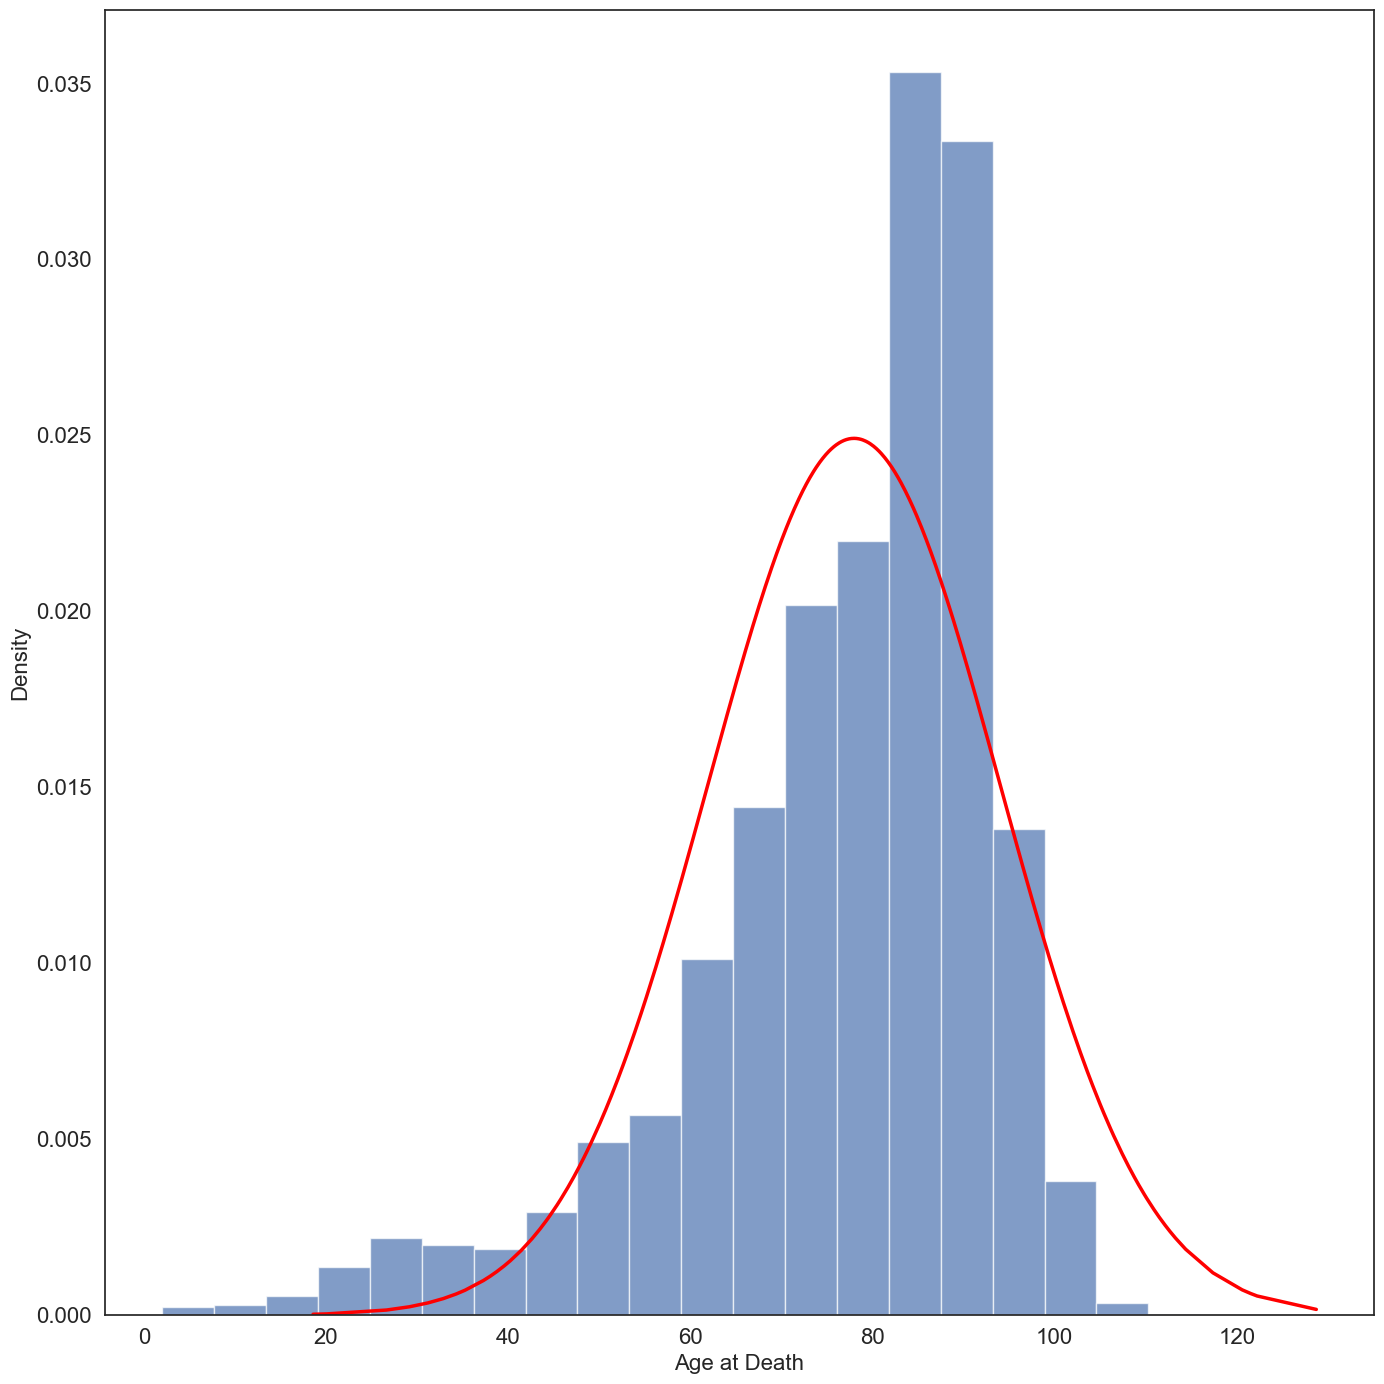

In [32]:
ax = plt.subplot2grid((1,1), (0,0))

ax = df.hist(density=True, bins=20, alpha=0.7)
ax.plot(h, pdf, color='red', lw=2.5)

ax.set_ylabel("Density", fontsize=xlarge)
ax.set_xlabel('Age at Death', fontsize=xlarge)
ax.tick_params(axis='both', which='major', labelsize=xlarge)

plt.grid(False)

plt.tight_layout()

Figure 2.13: A histogram and PDF (overlaid in red) for age at death of notable individuals in 2016, demonstrating that the data set is negatively
skewed.

## Positive skew
**Example 2.12**: Consider the Ames Housing data set, recording 1,460 property sale prices in Ames USA, including the year sold, sale type, sale condition and sale price in US dollars; In Figure 2.12 the histogram of the data set is shown, together with the PDF (overlaid in red) of a normal distribution with the same mean and standard deviation as the original data set. It can be seen that the data set is positively skewed.

In [33]:
df = pd.read_csv('./data/house_prices.csv')
print(df.head())

# calculate parameters
sample = df['SalePrice']
sample = df['SalePrice'].tolist()
sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
print(len(sample))

# define the distribution
dist = norm(sample_mean, sample_std)

# sample probabilities for a range of outcomes
values = [value for value in range(500, 3000)]
probabilities = [dist.pdf(value) for value in values]
mu, sigma = sample_mean, sample_std # mean and standard deviation
h = np.random.normal(mu, sigma, 500)
h.sort()

hmean = np.mean(h)
hstd = np.std(h)
pdf = norm.pdf(h, hmean, hstd)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Table 2.12: Sample of the data recording the sale prices of houses in US dollars in Ames, USA.

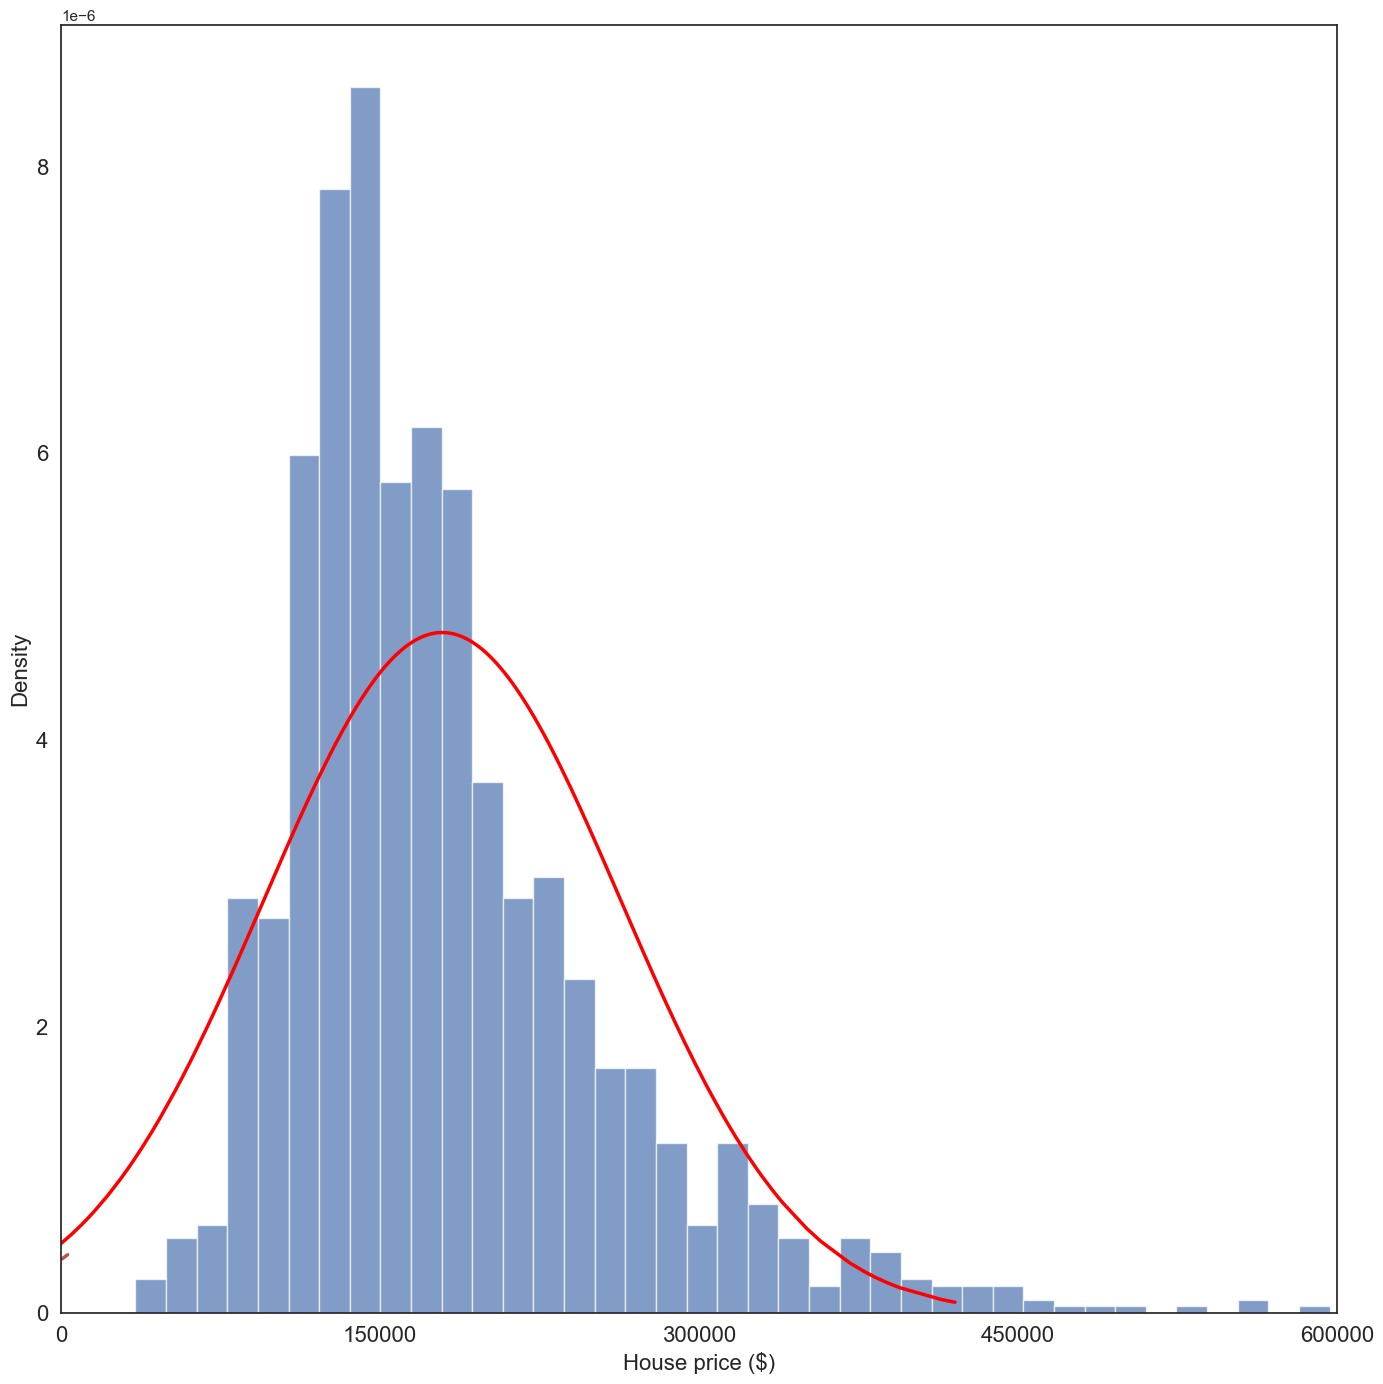

In [34]:
ax = plt.subplot2grid((1,1), (0,0))
ax.hist(sample, bins=50, density=True, alpha=0.7)
ax.plot(values, probabilities, color='r', lw=2.5, label="PDF")
ax.plot(h, pdf, color='red', lw=2.5)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlim([0, 600000])
ax.set_xlabel("House price ($)", fontsize=xlarge)
ax.set_ylabel("Density", fontsize=xlarge)
ax.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.12: A histogram and PDF (overlaid in red) for the sales price of properties, demonstrating that the data set is positively skewed.

# Kurtosis
Example 2.14. Consider a Bitcoin cryptocurrency data set composed of the 
hourly recorded value of Bitcoin over the course of a year (from 01/01/202 
to 07/01/2021), totalling 8,929 rows; see Table 2.14 for a sample of the firstorder differences, derived from the original data set by recording t e chan e
in value of Bitcoin at consecutive time points. In Figure 2.14 the histog am
of the first-order differences of the data set is shown, together with the PDF
(overlaid in red) of the maximum likelihood fit of a normal distributi n to
the data. It can be seen that the kurtosis of the data set, calcula ed as
59.76, is high relative to the normal distribution, whic is 0.


In [35]:
df = pd.read_csv('./data/bitcoin.txt', names=['difference'])
print(df.head())
print("Kurtosis", df.kurt())

sample = df['difference'].tolist()

# calculate parameters
sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))

# define the distribution
dist = norm(sample_mean, sample_std)

# sample probabilities for a range of outcomes
values = [value for value in range(-500, 500)]
probabilities = [dist.pdf(value) for value in values]

   difference
0       47.17
1       24.17
2      -23.34
3       -9.38
4        5.89
Kurtosis difference    59.769177
dtype: float64
Mean=3.319, Standard Deviation=103.341


Table 2.14: Sample of the data showing the first-order differences of Bitcoin values.

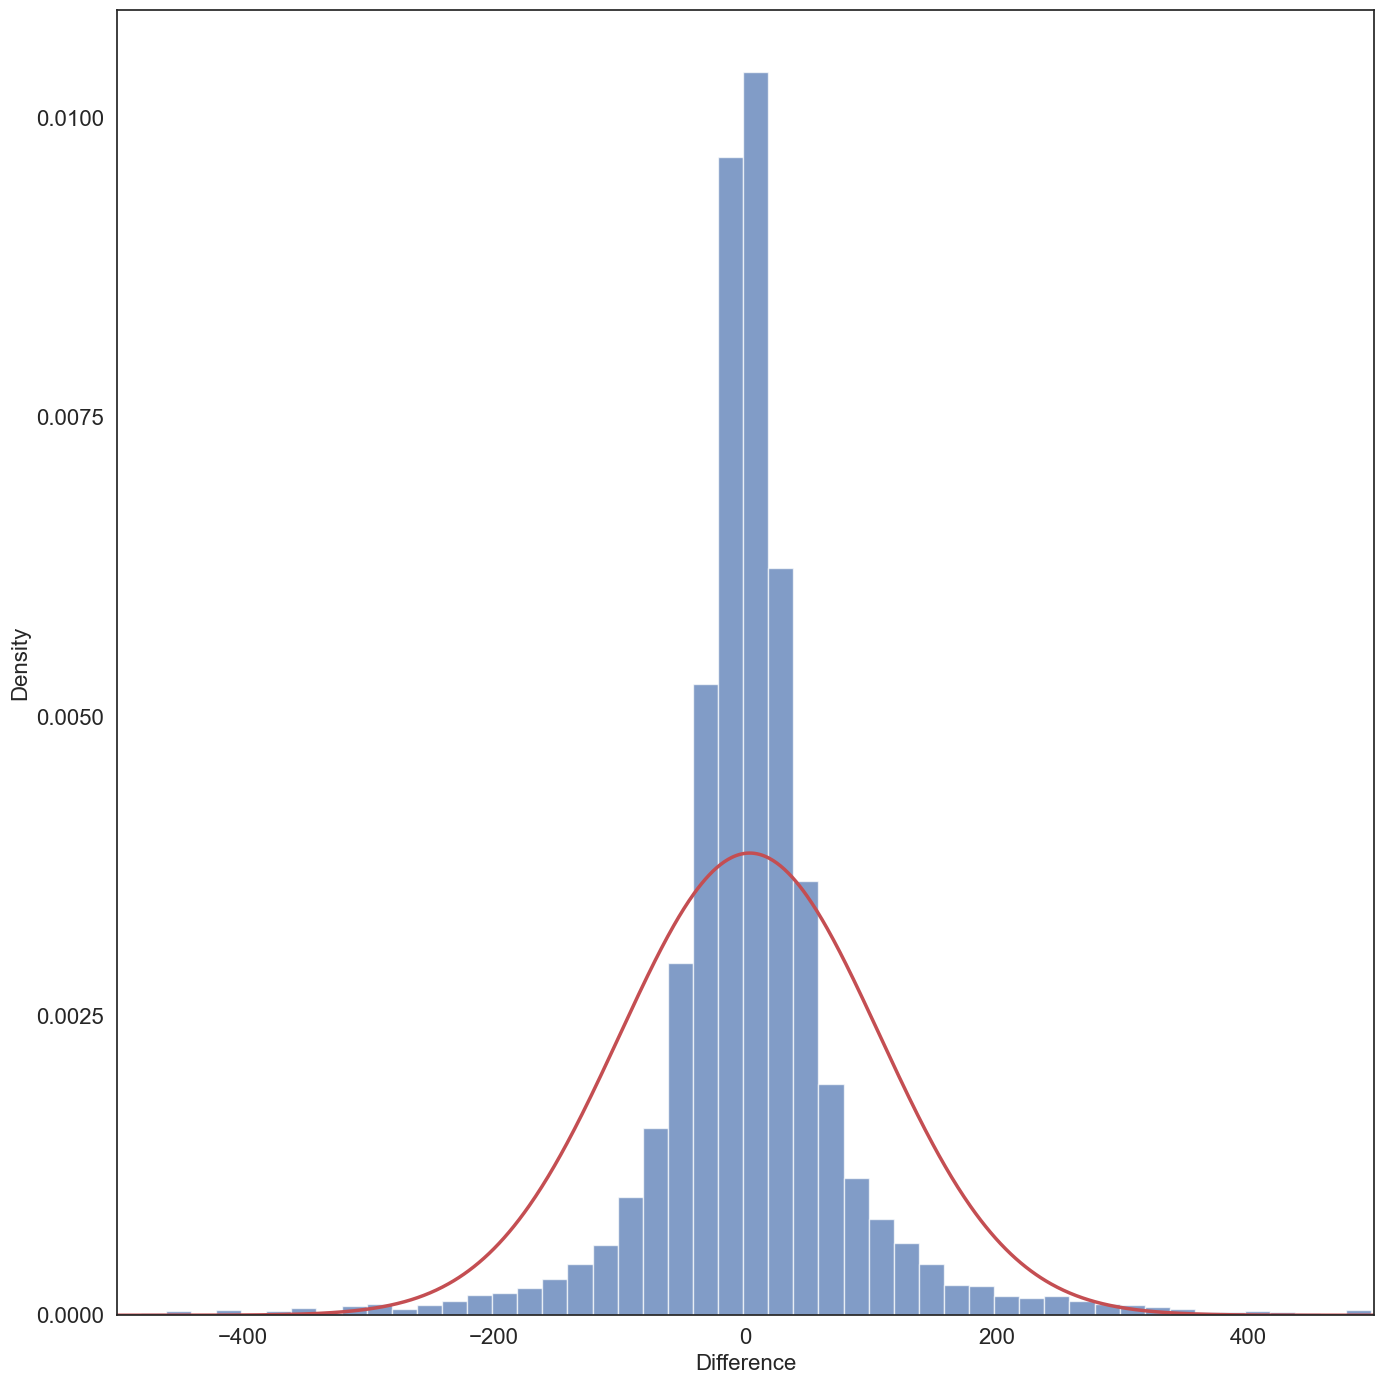

In [36]:
ax1 = plt.subplot2grid((1,1), (0,0))

# plot the histogram and pdf
ax1.hist(sample, bins=182, density=True, alpha=0.7)
ax1.plot(values, probabilities, color='r', lw=2.5, label="PDF")

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([-500, 500])
ax1.set_xlabel("Difference", fontsize=xlarge)
ax1.set_ylabel("Density", fontsize=xlarge)
ax1.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 2.14: The histogram and PDF of the maximum likelihood fit of the normal distribution (overlaid in red), for the first-order differences of the value of Bitcoin, demonstrating that the excess kurtosis present in the data set is high.

# Correlation (scatter plot)
A scatter plot visualises such a sample of 
pairs, so that each (x
, yi) is plotted as a dot on the display; an example  f
six scatter plots is shown in Figure 2.15. A fitted regression line, is a l ne
that can be added to a scatter plot, as shown in Figure 2.15, that repres nts
a possible l rear relationship between X .and Y

In [37]:
def getDist(corr):
    xx = np.array([-0.51, 51.2])
    yy = np.array([0.33, 51.6])
    means = [xx.mean(), yy.mean()]  
    stds = [xx.std() / 3, yy.std() / 3]
    #corr = -0.8         # correlation
    covs = [[stds[0] ** 2, stds[0] * stds[1] * corr], 
            [stds[0] * stds[1] * corr, stds[1] ** 2]] 

    m = np.random.multivariate_normal(means, covs, 1000).T
    return m

def getFit(x1,y1, ax):
    #fit function
    x = np.array([0, 50])
    a, b = np.polyfit(np.array(x1), np.array(y1), deg=1)
    f = lambda x: a * x + b
    ax.plot(x, f(x), lw=2.5, c="red",label="fit line between 0 and 100")  
    ax.set_ylabel("y")
    ax.set_xlabel("x")

x, y = getDist(0.4)

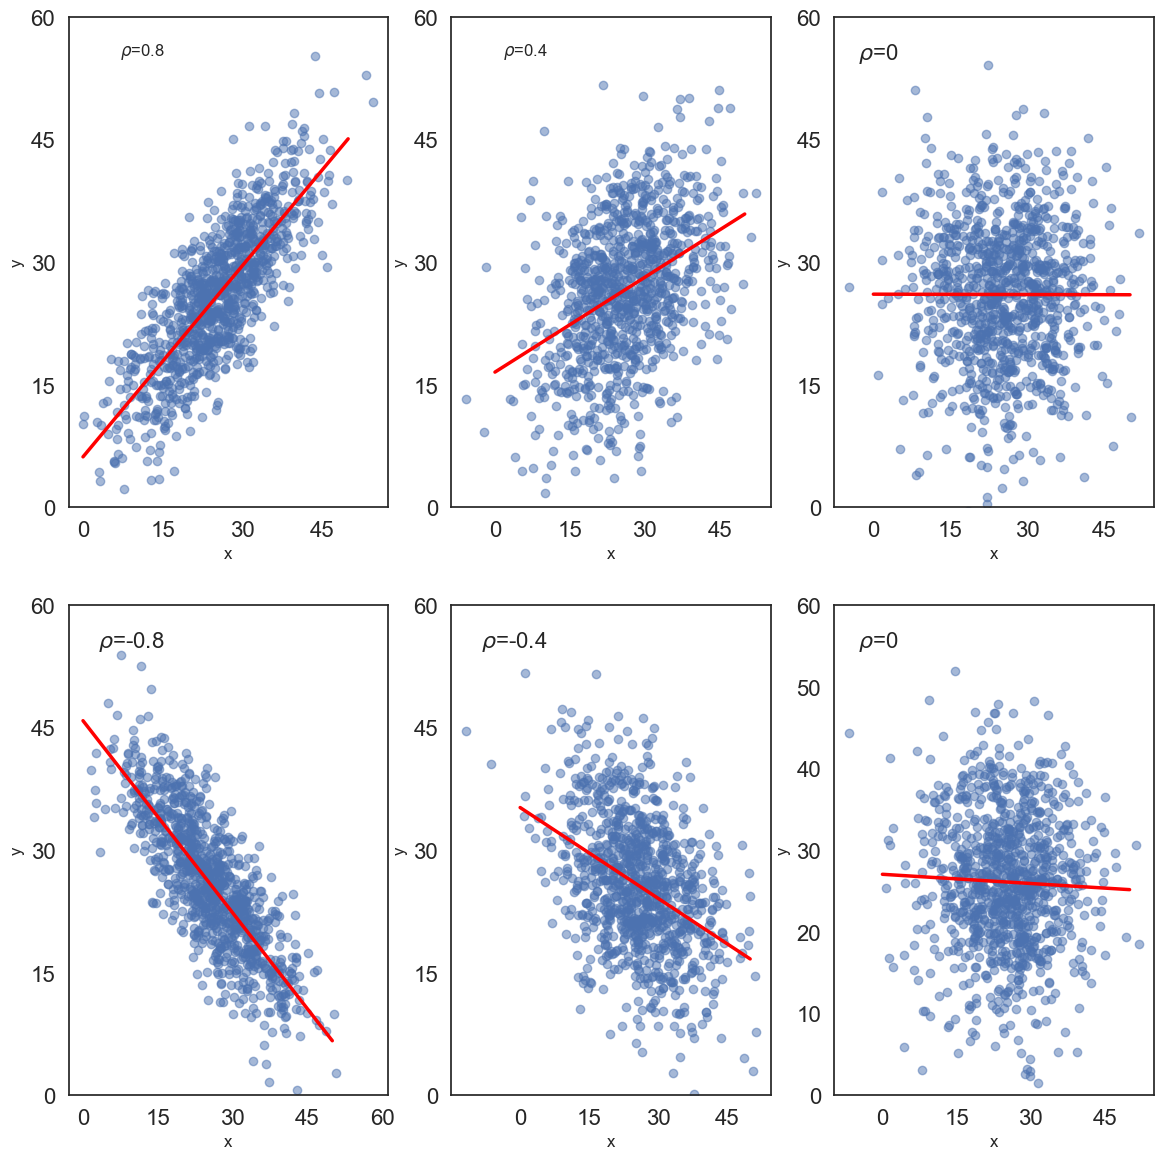

In [38]:
ax1 = plt.subplot2grid((2,3), (0,0))
ax2 = plt.subplot2grid((2,3), (0,1))
ax3 = plt.subplot2grid((2,3), (0,2))

ax4 = plt.subplot2grid((2,3), (1,0))
ax5 = plt.subplot2grid((2,3), (1,1))
ax6 = plt.subplot2grid((2,3), (1,2))
ax2.scatter(x, y, alpha=0.5)
ax2.annotate(r'$\rho$=' + str(0.4),
            xy=(1, 8), xycoords='data',
            xytext=(0.3, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top')
getFit(x, y, ax2)
ax2.set_ylim([0,60])


x, y = getDist(0.8)
ax1.scatter(x,y, alpha=0.5)
ax1.annotate(r'$\rho$=' + str(0.8),
            xy=(1, 8), xycoords='data',
            xytext=(0.3, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top')
getFit(x, y, ax1)
ax1.set_ylim([0,60])

x, y = getDist(0)
ax3.scatter(x, y, alpha=0.5)
ax3.annotate(r'$\rho$=' + str(0),
            xy=(3, 8), xycoords='data',
            xytext=(0.2, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', fontsize=xlarge)
getFit(x, y, ax3)
ax3.set_ylim([0,60])

x, y = getDist(-0.4)
ax5.scatter(x, y, alpha=0.5)
ax5.annotate(r'$\rho$=' + str(-0.4),
            xy=(1, 8), xycoords='data',
            xytext=(0.3, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', fontsize=xlarge)
getFit(x, y, ax5)
ax4.set_ylim([0,60])

x, y = getDist(-0.8)
ax4.scatter(x, y, alpha=0.5)
ax4.annotate(r'$\rho$=' + str(-0.8),
            xy=(1, 8), xycoords='data',
            xytext=(0.3, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', fontsize=xlarge)
getFit(x, y, ax4)
ax5.set_ylim([0,60])

x, y = getDist(0)
ax6.scatter(x, y, alpha=0.5)
ax6.annotate(r'$\rho$=' + str(0),
            xy=(1, 8), xycoords='data',
            xytext=(0.2, 0.95), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', fontsize=xlarge)
getFit(x, y, ax6)
ax6.set_ylim([0,60])

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
ax4.xaxis.set_major_locator(plt.MaxNLocator(5))
ax4.yaxis.set_major_locator(plt.MaxNLocator(5))
ax5.xaxis.set_major_locator(plt.MaxNLocator(5))
ax5.yaxis.set_major_locator(plt.MaxNLocator(5))
ax6.xaxis.set_major_locator(plt.MaxNLocator(5))

ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)
ax3.tick_params(axis='both', which='major', labelsize=xlarge)
ax4.tick_params(axis='both', which='major', labelsize=xlarge)
ax5.tick_params(axis='both', which='major', labelsize=xlarge)
ax6.tick_params(axis='both', which='major', labelsize=xlarge)

Figure 2.15: A scatter plot showing the correlation between two random variables X and Y on a synthetic data set with regression lines denoting the linear fit between X and Y. The reported Pearson correlation coefficient ρ appears in each subplot. The subplots in the top row illustrate positive
correlation, while those in the bottom row illustrate negative correlation.

# Regression and residuals
**Example 2.15**: Consider a data set from the Boston Standard Metropolitan 
Statistical Area (SMSA) in 1970, listing, for 506 properties drawn from the
area, various attributes including crime per capita (CRIM), average numb r
of rooms (RM), weighted distance to employment centres (DISTt, teac-erstudent school ratios (PTRATIO) and price in units of 1000 US doll rs
(price); see Table 215.


In [39]:
#boston = datasets.load_boston()
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

print(data.shape)
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']

bos = pd.DataFrame(data, columns = column_names)
bos['PRICE'] = target
print(bos[['CRIM', 'RM', 'DIS','PTRATIO', 'PRICE']].head())

X_rooms = np.array(bos.RM).reshape(-1,1)
y_price = np.array(bos.PRICE).reshape(-1,1)

print(X_rooms.shape)
print(y_price.shape)

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_rooms, y_price, test_size = 0.2, random_state=5)

print(X_train_1.shape)
print(X_test_1.shape)
print(Y_train_1.shape)
print(Y_test_1.shape)

reg_1 = LinearRegression()
reg_1.fit(X_train_1, Y_train_1)

y_train_predict_1 = reg_1.predict(X_train_1)
rmse = (np.sqrt(mean_squared_error(Y_train_1, y_train_predict_1)))
r2 = round(reg_1.score(X_train_1, Y_train_1),2)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for test set
y_pred_1 = reg_1.predict(X_test_1)
rmse = (np.sqrt(mean_squared_error(Y_test_1, y_pred_1)))
r2 = round(reg_1.score(X_test_1, Y_test_1), 2)

print("The model performance for training set")
print("--------------------------------------")
print("Root Mean Squared Error: {}".format(rmse))
print("R^2: {}".format(r2))
print("\n")

prediction_space = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1, 1) 


(506, 13)
      CRIM     RM     DIS  PTRATIO  PRICE
0  0.00632  6.575  4.0900     15.3   24.0
1  0.02731  6.421  4.9671     17.8   21.6
2  0.02729  7.185  4.9671     17.8   34.7
3  0.03237  6.998  6.0622     18.7   33.4
4  0.06905  7.147  6.0622     18.7   36.2
(506, 1)
(506, 1)
(404, 1)
(102, 1)
(404, 1)
(102, 1)
The model performance for training set
--------------------------------------
RMSE is 6.972277149440585
R2 score is 0.43


The model performance for training set
--------------------------------------
Root Mean Squared Error: 4.895963186952216
R^2: 0.69




Table 2.15: A sample of data from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970, listing various attributes including crime per capita (CRIM), average number of rooms (RM), weighted distance to employment centres (DIST), teacher-student school ratios (PTRATIO) and price in units of 1000 US dollars.

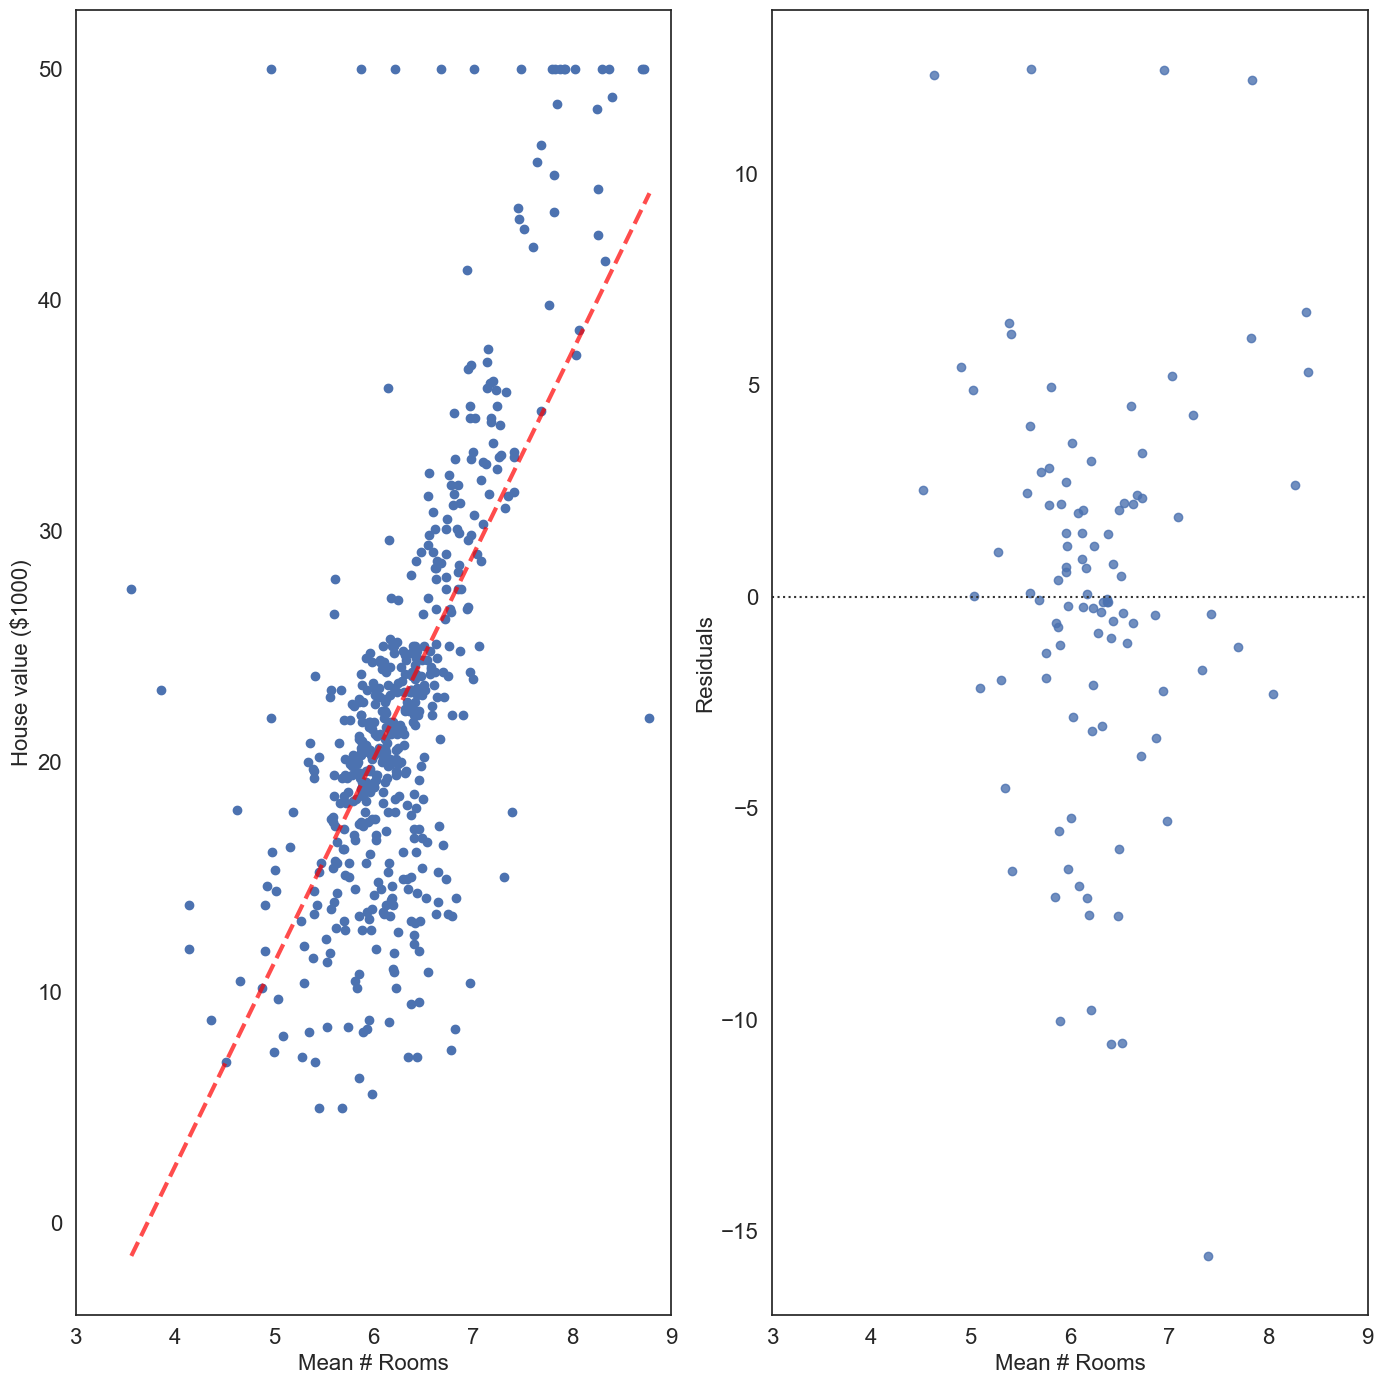

In [40]:
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

ax1.scatter(X_rooms,y_price)
ax1.plot(prediction_space, reg_1.predict(prediction_space), "--",color = 'red',linewidth = 3, alpha=0.7)

ax1.set_ylabel('House value ($1000)', fontsize=xlarge)
ax1.set_xlabel('Mean # Rooms', fontsize=xlarge)
ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax1.set_xlim([3,9])

sns.residplot(x=X_test_1, y=Y_test_1)

ax2.set_xlabel('Mean # Rooms', fontsize=xlarge)
ax2.set_ylabel('Residuals', fontsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.set_xlim([3,9])

plt.tight_layout()

Figure 2.16: A scatter plot (left) of the price plotted against the average number of rooms (RM) in a property overlaid with a red line denoting the least squared linear fit, and the corresponding residual errors (right).

# Logistic regression
Example 2.16. Consider a data set used predict the onset of diabetes based 
on medical predictors and an dependent variable representing the diagnostic
outcome(see e Table 2.)16, where BMI stands for body mass index and D F
stands for diabetes pedigree function. In the data set all patients in the d ta
are female and at least 21 years of age and from Pima Indian herit ge.
We use the independent variable BMI is used to predict the depe dent
variable Outcome, which has two possible values Diabetes and No Dia etes.
Logistic regression using the method of maximum likelihood estima ion is
applied to fit the parameters. In Figure 2.17 we show the plotted  ogistic
regression together a 95% confidence interval; the confidence interal representing the 2.5th and 97.5th percentiles was computed from a boo strap of
10,000 resamples of the data.

In [41]:
# load dataset
df = pd.read_csv("./data/diabetes.csv", header=0, delimiter="\t")
print(df.head())

feature_cols = ['BMI']
X = df[feature_cols] # Features
Y = df.Outcome # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

accuracyScore = accuracy_score(y_test, y_pred)
print('Accuracy Score (%): ',accuracyScore)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Accuracy Score (%):  0.6875


Table 2.16: A sample of data from the diagnostic data set used to predict the onset of Diabetes for Pima women.

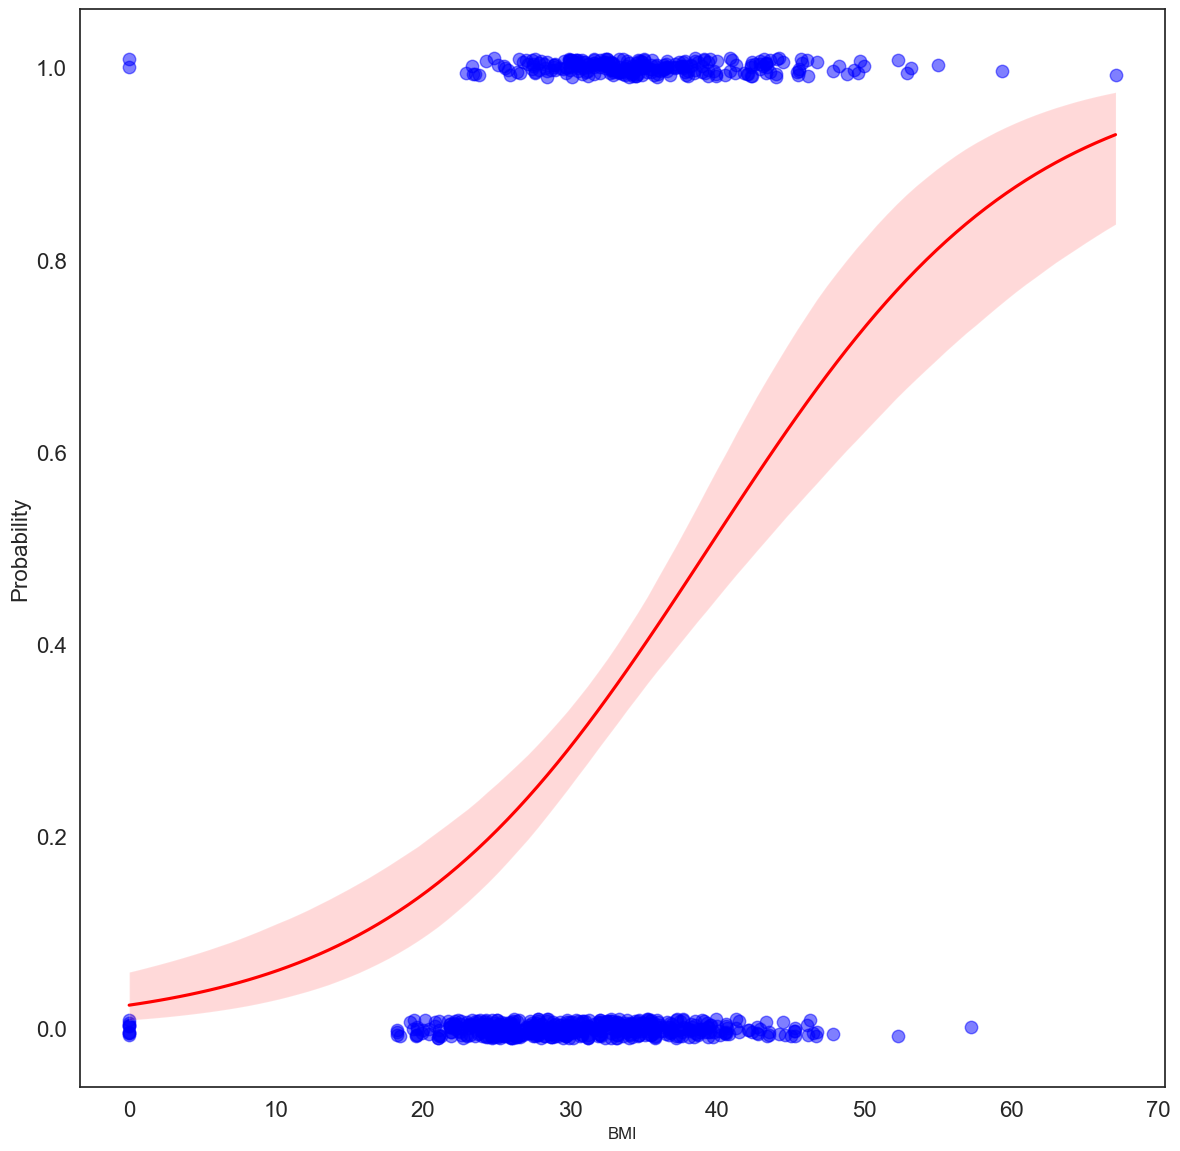

In [42]:
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=xlarge)

ax = sns.regplot(data=df, x='BMI', y='Outcome', logistic=True, y_jitter=.01, x_ci='ci', ci=97.5, n_boot=10000, scatter_kws={'color': 'blue', 's': 80, 'alpha': 0.5}, line_kws={'color': 'red'})

ax.set_ylabel("Probability", fontsize=xlarge)
ax.tick_params(axis='both', which='major', labelsize=xlarge)

fig = ax.get_figure()

Figure 2.17: A logistic regression plot showing the classification of the data points into those with Diabetes (top blue data point), and those without (bottom blue data points). A regression curve has been fit to the data with a 95% confidence interval computed from 10,000 bootstrap resamples.